<a href="https://colab.research.google.com/github/hatef-hosseinpour/dental-clf/blob/main/dental_classification_binaryclasses_version2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
from PIL import Image
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 30
NORMALIZATION_MEAN = [0.5, 0.5, 0.5]
NORMALIZATION_STD = [0.5, 0.5, 0.5]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)
])

In [ ]:
class DentalDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
def load_data(data_dir, label_mapping):
    images = []
    labels = []
    for folder, label in label_mapping.items():
        folder_path = os.path.join(data_dir, folder)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            if image is not None:
                image = Image.fromarray(image)
                images.append(image)
                labels.append(label)
    return images, labels

In [ ]:
def save_best_model(model, val_accuracy, best_accuracy, model_name):
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        # torch.save(model.state_dict(), f"/content/drive/MyDrive/Dentisrty/panoramic_data/{model_name}_best.pth")
        # torch.save(model.state_dict(), f"/content/drive/MyDrive/panoramic_data/{model_name}_best.pth")
    return best_accuracy

In [ ]:
metrics_df = pd.DataFrame(columns=[
    "Model Name", "Epochs", "Test Accuracy", "Precision", "Recall",
    "F1 Score", "FPR", "TPR", "AUC"
])

In [ ]:
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, model_name, class_map, patience=20):
    global metrics_df
    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for idx, (inputs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader.dataset):.4f}')

        # Evaluate on validation set
        val_accuracy, _ = evaluate_model(model, val_loader)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = save_best_model(model, val_accuracy, best_val_accuracy, model_name)
            print(f"Validation Accuracy after Epoch {epoch+1}: {val_accuracy:.4f} (improved)")
            epochs_without_improvement = 0  # Reset the counter
        else:
            print(f"Validation Accuracy after Epoch {epoch+1}: {val_accuracy:.4f} (no improvement)")
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    print(f"Best model for {model_name} saved with validation accuracy: {best_val_accuracy:.4f}")

    # Evaluate on test set
    test_accuracy, metrics = evaluate_model(model, test_loader)
    print(f"Test Accuracy for {model_name}")
    print(f'Accuracy: {test_accuracy:.4f}')
    print(f'Confusion Matrix:\n{metrics["confusion_matrix"]}')
    cm = metrics["confusion_matrix"]
    plt.figure(figsize=(10, 8))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)

    # Set labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(class_map)
    ax.set_yticklabels(class_map)

    plt.tight_layout()
    plt.show()

    print(f'Precision: {metrics["precision"]:.4f}')
    print(f'Recall: {metrics["recall"]:.4f}')
    print(f'F1 Score: {metrics["f1_score"]:.4f}')
    print(f'FPR: {metrics["fpr"]:.4f}')
    print(f'TPR: {metrics["tpr"]:.4f}')
    print(f'AUC: {metrics["auc"]:.4f}')

    # Save metrics
    new_row = pd.DataFrame([{
        "Model Name": model_name,
        "Epochs": epoch + 1,
        "Test Accuracy": test_accuracy,
        "Precision": metrics["precision"],
        "Recall": metrics["recall"],
        "F1 Score": metrics["f1_score"],
        "FPR": metrics["fpr"],
        "TPR": metrics["tpr"],
        "AUC": metrics["auc"]
    }])
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)
    metrics_df.to_csv("/content/drive/MyDrive/panoramic_data/model_metrics.csv", index=False)
    print(f"Metrics saved to DataFrame.\n{metrics_df}")


In [ ]:
def calculate_metrics(y_true, y_pred, y_prob):
    # Confusion matrix
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)


    # Calculate precision, recall, and f1-score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Calculate TPR and FPR
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)
    # Return all metrics
    return {
        "accuracy" : acc,
        "confusion_matrix": cm,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "fpr": fpr[1],
        "tpr": tpr[1],
        "roc_curve": (fpr, tpr),
        "auc": auc_score
    }

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for idx, (inputs, labels) in tqdm(enumerate(test_loader), total=len(test_loader)):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())


    accuracy = accuracy_score(all_labels, all_preds)
    metrics = calculate_metrics(all_labels, all_preds, all_probs)



    return accuracy, metrics

In [ ]:
def build_pretrained_model(model_name, num_classes):
    """Create a model with pretrained weights and add Dropout for regularization"""
    if model_name == 'resnet18':
        model = models.resnet18(weights='IMAGENET1K_V1')
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(model.fc.in_features, num_classes)
        )
    elif model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V1')
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(model.fc.in_features, num_classes)
        )
    elif model_name == 'vgg16':
        model = models.vgg16(weights='IMAGENET1K_V1')
        model.classifier[6] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(model.classifier[6].in_features, num_classes)
        )
    elif model_name == 'efficientnet_b4':
        model = models.efficientnet_b4(weights='IMAGENET1K_V1')
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
    elif model_name == 'densenet121':
        model = models.densenet121(weights='IMAGENET1K_V1')
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
    elif model_name == 'mobilenet_v3_large':
        model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
        in_features = model.classifier[3].in_features
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[0].in_features, model.classifier[0].out_features),
            nn.Hardswish(),
            nn.Dropout(0.5),  # اضافه شده
            nn.Linear(in_features, num_classes)
        )
    elif model_name == 'vit_b_16':
        model = models.vit_b_16(weights='IMAGENET1K_V1')
        model.heads.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(model.heads.head.in_features, num_classes)
        )
    elif model_name == 'vit_b_32':
        model = models.vit_b_32(weights='IMAGENET1K_V1')
        model.heads.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(model.heads.head.in_features, num_classes)
        )
    else:
        raise ValueError(f"Model {model_name} not supported")

    return model.to(DEVICE)


In [ ]:
# Predict function for unseen images
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = data_transforms(image).unsqueeze(0)
    return image

def load_model(model_path, model_class):
    model = model_class()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict_image(image_path, model_path1, model_path2, model_class):
    image_tensor = preprocess_image(image_path).to(DEVICE)

    # Model 1: Caries detection
    model1 = load_model(model_path1, model_class).to(DEVICE)

    with torch.no_grad():
        output1 = model1(image_tensor)
        prob1 = torch.sigmoid(output1).item()

        if prob1 < 0.5:  # Predicts Caries (class 0)
            print("caries")
        else:
            # Load and use model2 (to check if it's Amalgam or Normal)
            model2 = load_model(model_path2, model_class).to(DEVICE)
            output2 = model2(image_tensor)
            prob2 = torch.sigmoid(output2).item()

            # Model 2: Amalgam vs Normal
            if prob2 < 0.5:
                print("amalgam_filling")
            else:
                print("healthy")

Loading data...
Splitting data...
Preparing dataloaders...
Training model: vit_b_32 for Caries Detection


100%|██████████| 8/8 [00:03<00:00,  2.64it/s]


Epoch 1/30, Loss: 0.9827


100%|██████████| 3/3 [00:00<00:00, 10.03it/s]


Validation Accuracy after Epoch 1: 0.7538 (improved)


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Epoch 2/30, Loss: 0.5812


100%|██████████| 3/3 [00:00<00:00, 10.86it/s]


Validation Accuracy after Epoch 2: 0.7538 (no improvement)


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Epoch 3/30, Loss: 0.5935


100%|██████████| 3/3 [00:00<00:00, 10.49it/s]


Validation Accuracy after Epoch 3: 0.7692 (improved)


100%|██████████| 8/8 [00:02<00:00,  2.68it/s]


Epoch 4/30, Loss: 0.5288


100%|██████████| 3/3 [00:00<00:00, 11.18it/s]


Validation Accuracy after Epoch 4: 0.6923 (no improvement)


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Epoch 5/30, Loss: 0.4875


100%|██████████| 3/3 [00:00<00:00, 10.84it/s]


Validation Accuracy after Epoch 5: 0.8000 (improved)


100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Epoch 6/30, Loss: 0.4593


100%|██████████| 3/3 [00:00<00:00, 10.48it/s]


Validation Accuracy after Epoch 6: 0.6923 (no improvement)


100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


Epoch 7/30, Loss: 0.4594


100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


Validation Accuracy after Epoch 7: 0.7692 (no improvement)


100%|██████████| 8/8 [00:02<00:00,  2.70it/s]


Epoch 8/30, Loss: 0.4894


100%|██████████| 3/3 [00:00<00:00,  8.31it/s]


Validation Accuracy after Epoch 8: 0.7846 (no improvement)


100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


Epoch 9/30, Loss: 0.4726


100%|██████████| 3/3 [00:00<00:00, 10.79it/s]


Validation Accuracy after Epoch 9: 0.7231 (no improvement)


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 10/30, Loss: 0.4771


100%|██████████| 3/3 [00:00<00:00, 10.46it/s]


Validation Accuracy after Epoch 10: 0.7231 (no improvement)


100%|██████████| 8/8 [00:02<00:00,  2.80it/s]


Epoch 11/30, Loss: 0.4556


100%|██████████| 3/3 [00:00<00:00, 10.24it/s]


Validation Accuracy after Epoch 11: 0.7538 (no improvement)


100%|██████████| 8/8 [00:02<00:00,  2.68it/s]


Epoch 12/30, Loss: 0.4990


100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


Validation Accuracy after Epoch 12: 0.7231 (no improvement)


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


Epoch 13/30, Loss: 0.5296


100%|██████████| 3/3 [00:00<00:00,  9.98it/s]


Validation Accuracy after Epoch 13: 0.6769 (no improvement)


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 14/30, Loss: 0.5076


100%|██████████| 3/3 [00:00<00:00, 10.31it/s]


Validation Accuracy after Epoch 14: 0.7846 (no improvement)


100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


Epoch 15/30, Loss: 0.4703


100%|██████████| 3/3 [00:00<00:00, 10.51it/s]


Validation Accuracy after Epoch 15: 0.6769 (no improvement)
Early stopping triggered after 15 epochs.
Best model for vit_b_32_caries saved with validation accuracy: 0.8000


100%|██████████| 3/3 [00:00<00:00,  8.35it/s]


Test Accuracy for vit_b_32_caries
Accuracy: 0.6790
Confusion Matrix:
[[15 15]
 [11 40]]


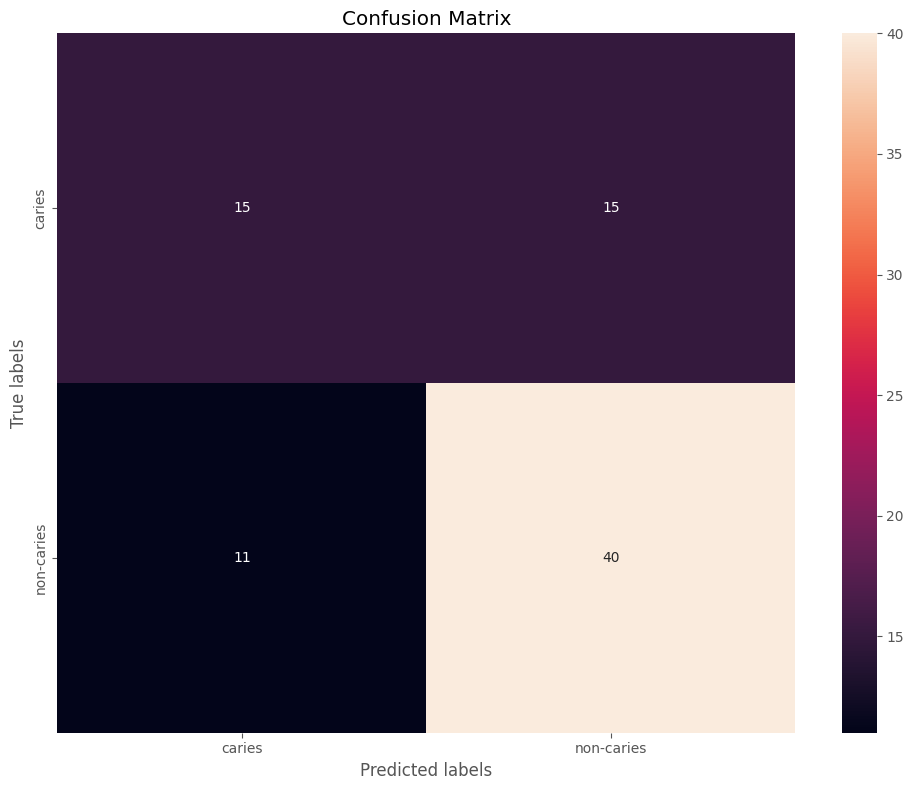

Precision: 0.7273
Recall: 0.7843
F1 Score: 0.7547
FPR: 0.0000
TPR: 0.0196
AUC: 0.7817
Metrics saved to DataFrame.
        Model Name Epochs  Test Accuracy  Precision    Recall  F1 Score  FPR  \
0  vit_b_32_caries     15       0.679012   0.727273  0.784314  0.754717  0.0   

        TPR       AUC  
0  0.019608  0.781699  
Training model: vit_b_32 for Non-Caries Detection


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


Epoch 1/30, Loss: 1.0738


100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


Validation Accuracy after Epoch 1: 0.5870 (improved)


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch 2/30, Loss: 0.7899


100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


Validation Accuracy after Epoch 2: 0.4130 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch 3/30, Loss: 0.7205


100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


Validation Accuracy after Epoch 3: 0.6522 (improved)


100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Epoch 4/30, Loss: 0.6689


100%|██████████| 2/2 [00:00<00:00, 10.38it/s]


Validation Accuracy after Epoch 4: 0.7174 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch 5/30, Loss: 0.5879


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Validation Accuracy after Epoch 5: 0.6957 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.80it/s]


Epoch 6/30, Loss: 0.3621


100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


Validation Accuracy after Epoch 6: 0.8478 (improved)


100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 7/30, Loss: 0.2675


100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


Validation Accuracy after Epoch 7: 0.8043 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 8/30, Loss: 0.2727


100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


Validation Accuracy after Epoch 8: 0.8261 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch 9/30, Loss: 0.2816


100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


Validation Accuracy after Epoch 9: 0.9348 (improved)


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch 10/30, Loss: 0.1939


100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


Validation Accuracy after Epoch 10: 0.8913 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch 11/30, Loss: 0.2173


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Validation Accuracy after Epoch 11: 0.8913 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


Epoch 12/30, Loss: 0.2470


100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


Validation Accuracy after Epoch 12: 0.8696 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epoch 13/30, Loss: 0.2221


100%|██████████| 2/2 [00:00<00:00,  9.98it/s]


Validation Accuracy after Epoch 13: 0.9130 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epoch 14/30, Loss: 0.2072


100%|██████████| 2/2 [00:00<00:00, 10.17it/s]


Validation Accuracy after Epoch 14: 0.8478 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch 15/30, Loss: 0.2191


100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


Validation Accuracy after Epoch 15: 0.8478 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch 16/30, Loss: 0.1550


100%|██████████| 2/2 [00:00<00:00, 10.57it/s]


Validation Accuracy after Epoch 16: 0.9348 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


Epoch 17/30, Loss: 0.1860


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Validation Accuracy after Epoch 17: 0.9348 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.87it/s]


Epoch 18/30, Loss: 0.1948


100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


Validation Accuracy after Epoch 18: 0.8913 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch 19/30, Loss: 0.1671


100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Validation Accuracy after Epoch 19: 0.8913 (no improvement)
Early stopping triggered after 19 epochs.
Best model for vit_b_32_non_caries saved with validation accuracy: 0.9348


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Test Accuracy for vit_b_32_non_caries
Accuracy: 0.9483
Confusion Matrix:
[[23  1]
 [ 2 32]]


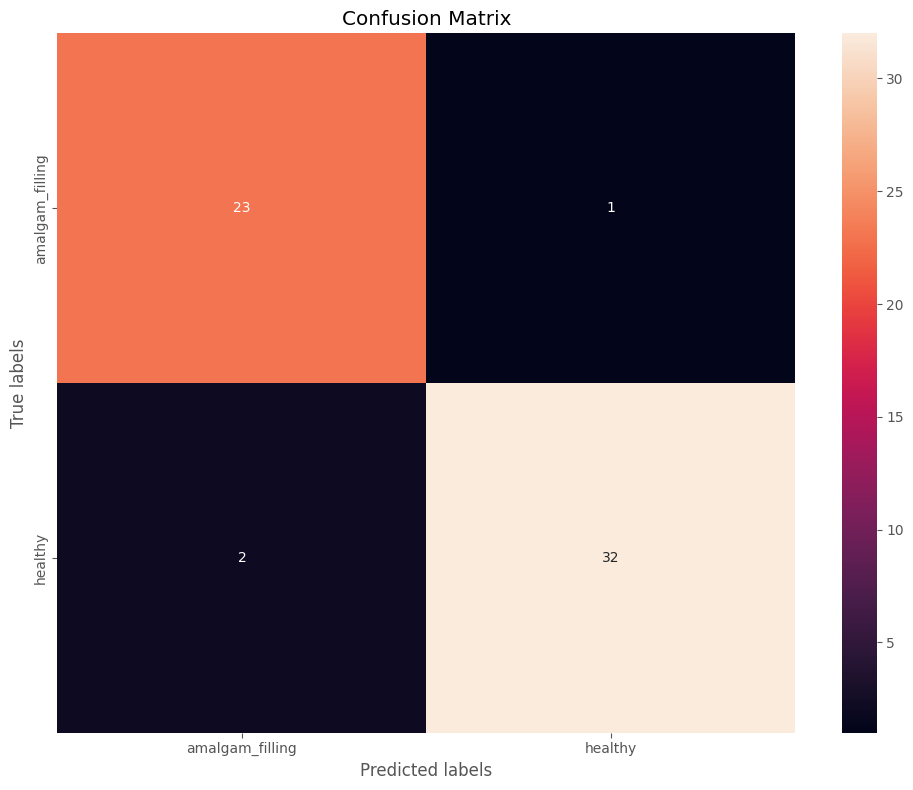

Precision: 0.9697
Recall: 0.9412
F1 Score: 0.9552
FPR: 0.0000
TPR: 0.0294
AUC: 0.9865
Metrics saved to DataFrame.
            Model Name Epochs  Test Accuracy  Precision    Recall  F1 Score  \
0      vit_b_32_caries     15       0.679012   0.727273  0.784314  0.754717   
1  vit_b_32_non_caries     19       0.948276   0.969697  0.941176  0.955224   

   FPR       TPR       AUC  
0  0.0  0.019608  0.781699  
1  0.0  0.029412  0.986520  
Training model: vit_b_16 for Caries Detection


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Epoch 1/30, Loss: 1.2239


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Validation Accuracy after Epoch 1: 0.4000 (improved)


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


Epoch 2/30, Loss: 0.7691


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Validation Accuracy after Epoch 2: 0.7538 (improved)


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


Epoch 3/30, Loss: 0.5937


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Validation Accuracy after Epoch 3: 0.7538 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


Epoch 4/30, Loss: 0.5753


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Validation Accuracy after Epoch 4: 0.7538 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Epoch 5/30, Loss: 0.5356


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Validation Accuracy after Epoch 5: 0.7692 (improved)


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Epoch 6/30, Loss: 0.5682


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Validation Accuracy after Epoch 6: 0.7538 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Epoch 7/30, Loss: 0.5852


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Validation Accuracy after Epoch 7: 0.7538 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Epoch 8/30, Loss: 0.5504


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Validation Accuracy after Epoch 8: 0.7846 (improved)


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Epoch 9/30, Loss: 0.5431


100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Validation Accuracy after Epoch 9: 0.7692 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Epoch 10/30, Loss: 0.5317


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Validation Accuracy after Epoch 10: 0.7692 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Epoch 11/30, Loss: 0.5387


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Validation Accuracy after Epoch 11: 0.7538 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Epoch 12/30, Loss: 0.5233


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Validation Accuracy after Epoch 12: 0.8000 (improved)


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Epoch 13/30, Loss: 0.5610


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Validation Accuracy after Epoch 13: 0.7077 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Epoch 14/30, Loss: 0.5725


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Validation Accuracy after Epoch 14: 0.7846 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Epoch 15/30, Loss: 0.5207


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Validation Accuracy after Epoch 15: 0.7538 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Epoch 16/30, Loss: 0.5453


100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Validation Accuracy after Epoch 16: 0.7538 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Epoch 17/30, Loss: 0.5008


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Validation Accuracy after Epoch 17: 0.7538 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Epoch 18/30, Loss: 0.4925


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Validation Accuracy after Epoch 18: 0.7692 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Epoch 19/30, Loss: 0.4719


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Validation Accuracy after Epoch 19: 0.6769 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Epoch 20/30, Loss: 0.4537


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Validation Accuracy after Epoch 20: 0.7846 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Epoch 21/30, Loss: 0.4692


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Validation Accuracy after Epoch 21: 0.7538 (no improvement)


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Epoch 22/30, Loss: 0.4983


100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Validation Accuracy after Epoch 22: 0.7846 (no improvement)
Early stopping triggered after 22 epochs.
Best model for vit_b_16_caries saved with validation accuracy: 0.8000


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

Test Accuracy for vit_b_16_caries
Accuracy: 0.6914
Confusion Matrix:
[[ 5 25]
 [ 0 51]]


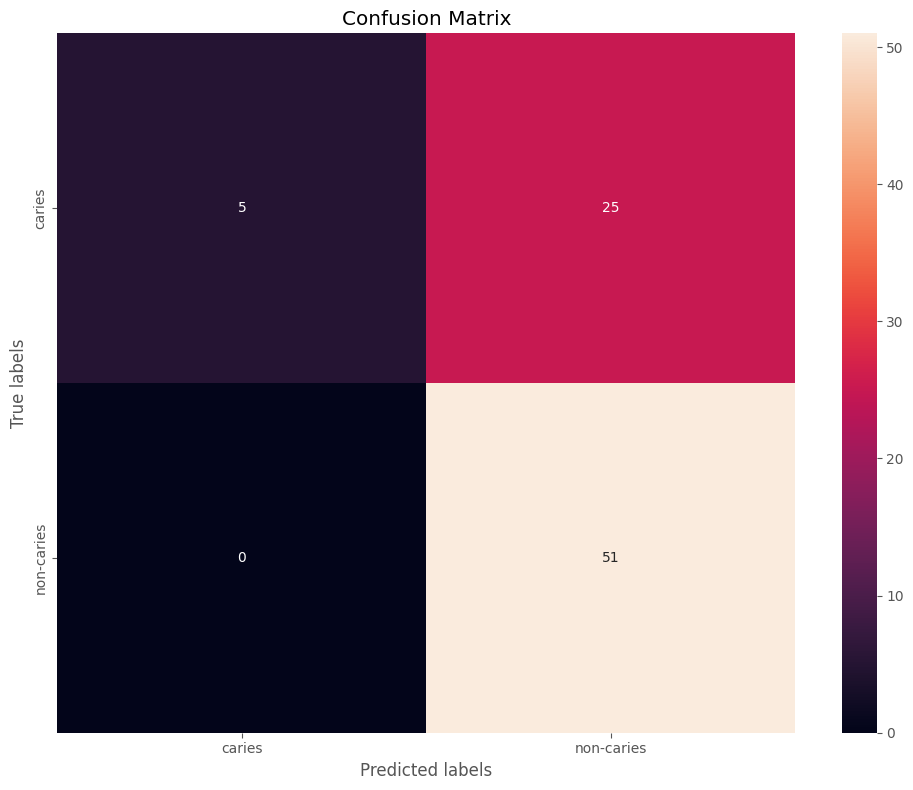

Precision: 0.6711
Recall: 1.0000
F1 Score: 0.8031
FPR: 0.0000
TPR: 0.0196
AUC: 0.7686
Metrics saved to DataFrame.
            Model Name Epochs  Test Accuracy  Precision    Recall  F1 Score  \
0      vit_b_32_caries     15       0.679012   0.727273  0.784314  0.754717   
1  vit_b_32_non_caries     19       0.948276   0.969697  0.941176  0.955224   
2      vit_b_16_caries     22       0.691358   0.671053  1.000000  0.803150   

   FPR       TPR       AUC  
0  0.0  0.019608  0.781699  
1  0.0  0.029412  0.986520  
2  0.0  0.019608  0.768627  
Training model: vit_b_16 for Non-Caries Detection


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 1/30, Loss: 2.1692


100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


Validation Accuracy after Epoch 1: 0.4130 (improved)


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Epoch 2/30, Loss: 0.8448


100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


Validation Accuracy after Epoch 2: 0.4130 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 3/30, Loss: 0.7466


100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


Validation Accuracy after Epoch 3: 0.5870 (improved)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 4/30, Loss: 0.7317


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


Validation Accuracy after Epoch 4: 0.4130 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 5/30, Loss: 0.7772


100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


Validation Accuracy after Epoch 5: 0.4130 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 6/30, Loss: 0.7772


100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Validation Accuracy after Epoch 6: 0.5870 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 7/30, Loss: 0.7243


100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


Validation Accuracy after Epoch 7: 0.4130 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 8/30, Loss: 0.6662


100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


Validation Accuracy after Epoch 8: 0.6087 (improved)


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Epoch 9/30, Loss: 0.5539


100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


Validation Accuracy after Epoch 9: 0.8261 (improved)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 10/30, Loss: 0.3380


100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


Validation Accuracy after Epoch 10: 0.8696 (improved)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 11/30, Loss: 0.3049


100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Validation Accuracy after Epoch 11: 0.9130 (improved)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 12/30, Loss: 0.1729


100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


Validation Accuracy after Epoch 12: 0.8913 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 13/30, Loss: 0.3590


100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


Validation Accuracy after Epoch 13: 0.8043 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 14/30, Loss: 0.3452


100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


Validation Accuracy after Epoch 14: 0.7174 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Epoch 15/30, Loss: 0.3004


100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


Validation Accuracy after Epoch 15: 0.8261 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 16/30, Loss: 0.2533


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


Validation Accuracy after Epoch 16: 0.9130 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Epoch 17/30, Loss: 0.2110


100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


Validation Accuracy after Epoch 17: 0.8696 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 18/30, Loss: 0.2259


100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Validation Accuracy after Epoch 18: 0.8913 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 19/30, Loss: 0.1817


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


Validation Accuracy after Epoch 19: 0.9348 (improved)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 20/30, Loss: 0.1771


100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


Validation Accuracy after Epoch 20: 0.9130 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 21/30, Loss: 0.1448


100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


Validation Accuracy after Epoch 21: 0.8913 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 22/30, Loss: 0.1404


100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


Validation Accuracy after Epoch 22: 0.8696 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 23/30, Loss: 0.1640


100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


Validation Accuracy after Epoch 23: 0.9348 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 24/30, Loss: 0.1661


100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


Validation Accuracy after Epoch 24: 0.9130 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 25/30, Loss: 0.1199


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


Validation Accuracy after Epoch 25: 0.9565 (improved)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 26/30, Loss: 0.1169


100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


Validation Accuracy after Epoch 26: 0.9130 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 27/30, Loss: 0.1244


100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


Validation Accuracy after Epoch 27: 0.9565 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 28/30, Loss: 0.1172


100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


Validation Accuracy after Epoch 28: 0.9565 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 29/30, Loss: 0.1029


100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


Validation Accuracy after Epoch 29: 0.9348 (no improvement)


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


Epoch 30/30, Loss: 0.1208


100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


Validation Accuracy after Epoch 30: 0.9348 (no improvement)
Best model for vit_b_16_non_caries saved with validation accuracy: 0.9565


100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

Test Accuracy for vit_b_16_non_caries
Accuracy: 0.9828
Confusion Matrix:
[[24  0]
 [ 1 33]]


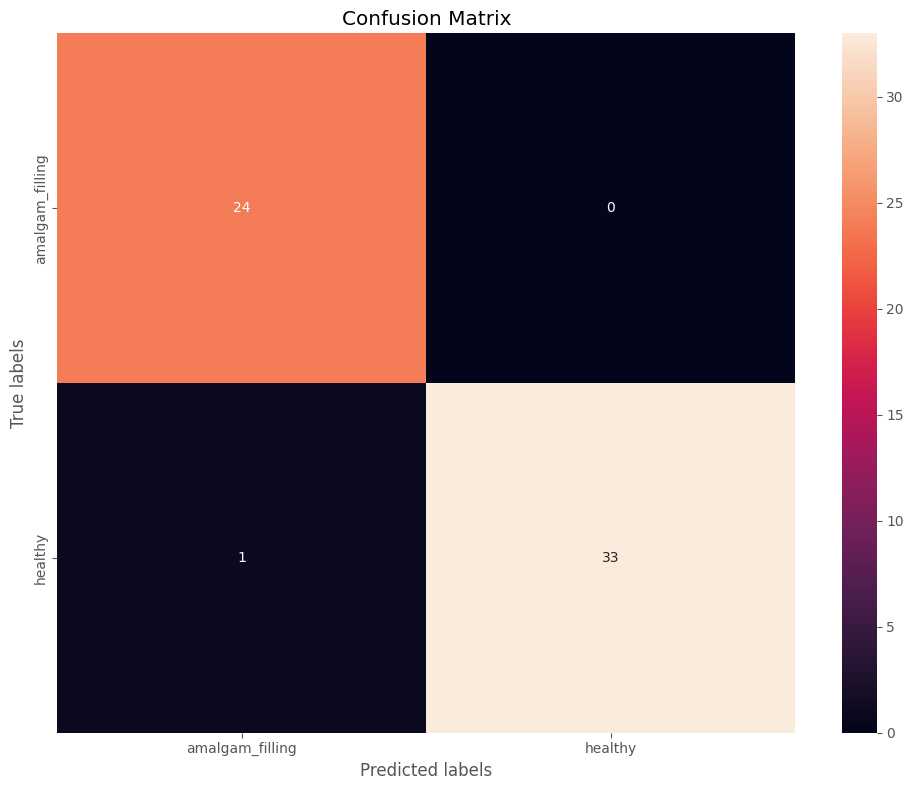

Precision: 1.0000
Recall: 0.9706
F1 Score: 0.9851
FPR: 0.0000
TPR: 0.0294
AUC: 1.0000
Metrics saved to DataFrame.
            Model Name Epochs  Test Accuracy  Precision    Recall  F1 Score  \
0      vit_b_32_caries     15       0.679012   0.727273  0.784314  0.754717   
1  vit_b_32_non_caries     19       0.948276   0.969697  0.941176  0.955224   
2      vit_b_16_caries     22       0.691358   0.671053  1.000000  0.803150   
3  vit_b_16_non_caries     30       0.982759   1.000000  0.970588  0.985075   

   FPR       TPR       AUC  
0  0.0  0.019608  0.781699  
1  0.0  0.029412  0.986520  
2  0.0  0.019608  0.768627  
3  0.0  0.029412  1.000000  


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 136MB/s] 


Training model: mobilenet_v3_large for Caries Detection


100%|██████████| 8/8 [00:01<00:00,  4.95it/s]


Epoch 1/30, Loss: 0.5586


100%|██████████| 3/3 [00:00<00:00, 12.65it/s]


Validation Accuracy after Epoch 1: 0.4462 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.72it/s]


Epoch 2/30, Loss: 0.4296


100%|██████████| 3/3 [00:00<00:00, 16.62it/s]


Validation Accuracy after Epoch 2: 0.5385 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.89it/s]


Epoch 3/30, Loss: 0.3757


100%|██████████| 3/3 [00:00<00:00, 15.61it/s]


Validation Accuracy after Epoch 3: 0.7077 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.83it/s]


Epoch 4/30, Loss: 0.3388


100%|██████████| 3/3 [00:00<00:00, 15.74it/s]


Validation Accuracy after Epoch 4: 0.6154 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.71it/s]


Epoch 5/30, Loss: 0.2934


100%|██████████| 3/3 [00:00<00:00, 17.05it/s]


Validation Accuracy after Epoch 5: 0.5846 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.70it/s]


Epoch 6/30, Loss: 0.2332


100%|██████████| 3/3 [00:00<00:00, 12.65it/s]


Validation Accuracy after Epoch 6: 0.6923 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


Epoch 7/30, Loss: 0.2681


100%|██████████| 3/3 [00:00<00:00, 12.93it/s]


Validation Accuracy after Epoch 7: 0.8000 (improved)


100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Epoch 8/30, Loss: 0.1838


100%|██████████| 3/3 [00:00<00:00, 16.47it/s]


Validation Accuracy after Epoch 8: 0.5692 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.79it/s]


Epoch 9/30, Loss: 0.1391


100%|██████████| 3/3 [00:00<00:00, 16.38it/s]


Validation Accuracy after Epoch 9: 0.8308 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.91it/s]


Epoch 10/30, Loss: 0.0971


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


Validation Accuracy after Epoch 10: 0.8154 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.77it/s]


Epoch 11/30, Loss: 0.1349


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Validation Accuracy after Epoch 11: 0.7692 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.84it/s]


Epoch 12/30, Loss: 0.0815


100%|██████████| 3/3 [00:00<00:00, 16.75it/s]


Validation Accuracy after Epoch 12: 0.7846 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.82it/s]


Epoch 13/30, Loss: 0.0811


100%|██████████| 3/3 [00:00<00:00, 16.68it/s]


Validation Accuracy after Epoch 13: 0.8308 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.79it/s]


Epoch 14/30, Loss: 0.1053


100%|██████████| 3/3 [00:00<00:00, 16.61it/s]


Validation Accuracy after Epoch 14: 0.7692 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.85it/s]


Epoch 15/30, Loss: 0.1460


100%|██████████| 3/3 [00:00<00:00, 13.02it/s]


Validation Accuracy after Epoch 15: 0.7846 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.68it/s]


Epoch 16/30, Loss: 0.1083


100%|██████████| 3/3 [00:00<00:00, 12.43it/s]


Validation Accuracy after Epoch 16: 0.7538 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Epoch 17/30, Loss: 0.0771


100%|██████████| 3/3 [00:00<00:00, 16.31it/s]


Validation Accuracy after Epoch 17: 0.7538 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.80it/s]


Epoch 18/30, Loss: 0.1408


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


Validation Accuracy after Epoch 18: 0.7846 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.84it/s]


Epoch 19/30, Loss: 0.0980


100%|██████████| 3/3 [00:00<00:00, 15.77it/s]


Validation Accuracy after Epoch 19: 0.7538 (no improvement)
Early stopping triggered after 19 epochs.
Best model for mobilenet_v3_large_caries saved with validation accuracy: 0.8308


100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


Test Accuracy for mobilenet_v3_large_caries
Accuracy: 0.6543
Confusion Matrix:
[[ 2 28]
 [ 0 51]]


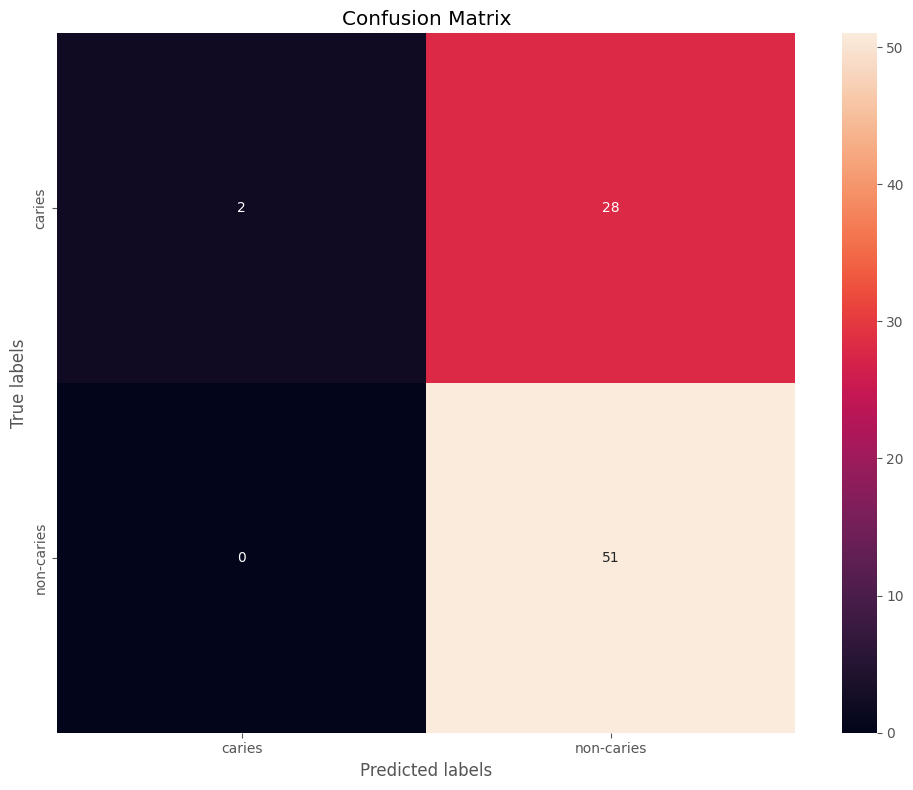

Precision: 0.6456
Recall: 1.0000
F1 Score: 0.7846
FPR: 0.0333
TPR: 0.1961
AUC: 0.6546
Metrics saved to DataFrame.
                  Model Name Epochs  Test Accuracy  Precision    Recall  \
0            vit_b_32_caries     15       0.679012   0.727273  0.784314   
1        vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2            vit_b_16_caries     22       0.691358   0.671053  1.000000   
3        vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4  mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   

   F1 Score       FPR       TPR       AUC  
0  0.754717  0.000000  0.019608  0.781699  
1  0.955224  0.000000  0.029412  0.986520  
2  0.803150  0.000000  0.019608  0.768627  
3  0.985075  0.000000  0.029412  1.000000  
4  0.784615  0.033333  0.196078  0.654575  
Training model: mobilenet_v3_large for Non-Caries Detection


100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


Epoch 1/30, Loss: 0.8195


100%|██████████| 2/2 [00:00<00:00, 13.53it/s]


Validation Accuracy after Epoch 1: 0.7826 (improved)


100%|██████████| 6/6 [00:00<00:00,  6.94it/s]


Epoch 2/30, Loss: 0.1298


100%|██████████| 2/2 [00:00<00:00, 16.32it/s]


Validation Accuracy after Epoch 2: 0.7826 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


Epoch 3/30, Loss: 0.0366


100%|██████████| 2/2 [00:00<00:00, 16.31it/s]


Validation Accuracy after Epoch 3: 0.6087 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.04it/s]


Epoch 4/30, Loss: 0.0671


100%|██████████| 2/2 [00:00<00:00, 16.05it/s]


Validation Accuracy after Epoch 4: 0.4565 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


Epoch 5/30, Loss: 0.0471


100%|██████████| 2/2 [00:00<00:00, 15.99it/s]


Validation Accuracy after Epoch 5: 0.5870 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Epoch 6/30, Loss: 0.0911


100%|██████████| 2/2 [00:00<00:00, 12.00it/s]


Validation Accuracy after Epoch 6: 0.6739 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


Epoch 7/30, Loss: 0.0732


100%|██████████| 2/2 [00:00<00:00, 10.81it/s]


Validation Accuracy after Epoch 7: 0.7826 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


Epoch 8/30, Loss: 0.0552


100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


Validation Accuracy after Epoch 8: 0.8261 (improved)


100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


Epoch 9/30, Loss: 0.0558


100%|██████████| 2/2 [00:00<00:00, 16.26it/s]


Validation Accuracy after Epoch 9: 0.9565 (improved)


100%|██████████| 6/6 [00:00<00:00,  6.99it/s]


Epoch 10/30, Loss: 0.0432


100%|██████████| 2/2 [00:00<00:00, 15.33it/s]


Validation Accuracy after Epoch 10: 0.9348 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.98it/s]


Epoch 11/30, Loss: 0.0337


100%|██████████| 2/2 [00:00<00:00, 15.95it/s]


Validation Accuracy after Epoch 11: 0.8261 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.04it/s]


Epoch 12/30, Loss: 0.0072


100%|██████████| 2/2 [00:00<00:00, 15.83it/s]


Validation Accuracy after Epoch 12: 0.7609 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.96it/s]


Epoch 13/30, Loss: 0.0139


100%|██████████| 2/2 [00:00<00:00, 15.85it/s]


Validation Accuracy after Epoch 13: 0.7609 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.95it/s]


Epoch 14/30, Loss: 0.0027


100%|██████████| 2/2 [00:00<00:00, 15.89it/s]


Validation Accuracy after Epoch 14: 0.6957 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.97it/s]


Epoch 15/30, Loss: 0.0013


100%|██████████| 2/2 [00:00<00:00, 15.78it/s]


Validation Accuracy after Epoch 15: 0.7609 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.94it/s]


Epoch 16/30, Loss: 0.0002


100%|██████████| 2/2 [00:00<00:00, 15.38it/s]


Validation Accuracy after Epoch 16: 0.7826 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.04it/s]


Epoch 17/30, Loss: 0.0002


100%|██████████| 2/2 [00:00<00:00, 15.47it/s]


Validation Accuracy after Epoch 17: 0.7391 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.99it/s]


Epoch 18/30, Loss: 0.0036


100%|██████████| 2/2 [00:00<00:00, 14.57it/s]


Validation Accuracy after Epoch 18: 0.7609 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.41it/s]


Epoch 19/30, Loss: 0.0013


100%|██████████| 2/2 [00:00<00:00, 12.10it/s]


Validation Accuracy after Epoch 19: 0.8043 (no improvement)
Early stopping triggered after 19 epochs.
Best model for mobilenet_v3_large_non_caries saved with validation accuracy: 0.9565


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Test Accuracy for mobilenet_v3_large_non_caries
Accuracy: 0.7759
Confusion Matrix:
[[23  1]
 [12 22]]


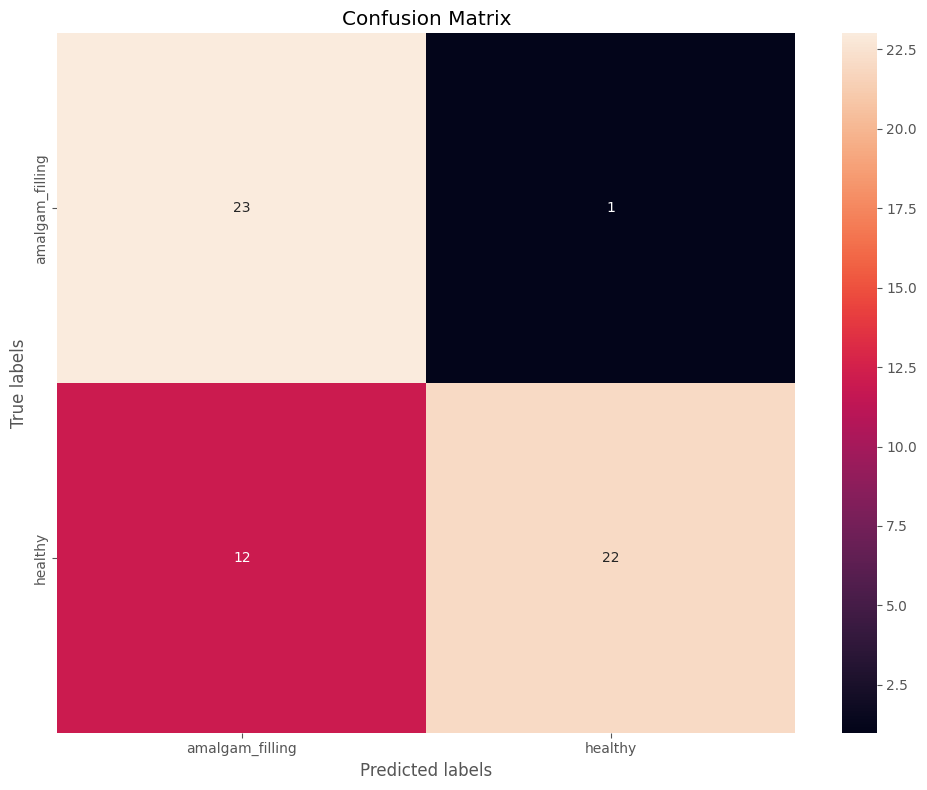

Precision: 0.9565
Recall: 0.6471
F1 Score: 0.7719
FPR: 0.0000
TPR: 0.0294
AUC: 0.9412
Metrics saved to DataFrame.
                      Model Name Epochs  Test Accuracy  Precision    Recall  \
0                vit_b_32_caries     15       0.679012   0.727273  0.784314   
1            vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                vit_b_16_caries     22       0.691358   0.671053  1.000000   
3            vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4      mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5  mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   

   F1 Score       FPR       TPR       AUC  
0  0.754717  0.000000  0.019608  0.781699  
1  0.955224  0.000000  0.029412  0.986520  
2  0.803150  0.000000  0.019608  0.768627  
3  0.985075  0.000000  0.029412  1.000000  
4  0.784615  0.033333  0.196078  0.654575  
5  0.771930  0.000000  0.029412  0.941176  


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 104MB/s]


Training model: densenet121 for Caries Detection


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch 1/30, Loss: 0.5292


100%|██████████| 3/3 [00:00<00:00,  7.28it/s]


Validation Accuracy after Epoch 1: 0.7538 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Epoch 2/30, Loss: 0.4035


100%|██████████| 3/3 [00:00<00:00,  8.51it/s]


Validation Accuracy after Epoch 2: 0.8308 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Epoch 3/30, Loss: 0.3396


100%|██████████| 3/3 [00:00<00:00,  8.67it/s]


Validation Accuracy after Epoch 3: 0.8154 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.43it/s]


Epoch 4/30, Loss: 0.3911


100%|██████████| 3/3 [00:00<00:00,  8.58it/s]


Validation Accuracy after Epoch 4: 0.8308 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Epoch 5/30, Loss: 0.3425


100%|██████████| 3/3 [00:00<00:00,  8.56it/s]


Validation Accuracy after Epoch 5: 0.6615 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Epoch 6/30, Loss: 0.2926


100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


Validation Accuracy after Epoch 6: 0.8308 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Epoch 7/30, Loss: 0.2825


100%|██████████| 3/3 [00:00<00:00,  7.15it/s]


Validation Accuracy after Epoch 7: 0.7538 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]


Epoch 8/30, Loss: 0.2237


100%|██████████| 3/3 [00:00<00:00,  8.45it/s]


Validation Accuracy after Epoch 8: 0.6462 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Epoch 9/30, Loss: 0.3318


100%|██████████| 3/3 [00:00<00:00,  8.56it/s]


Validation Accuracy after Epoch 9: 0.8000 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Epoch 10/30, Loss: 0.2706


100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


Validation Accuracy after Epoch 10: 0.7846 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.51it/s]


Epoch 11/30, Loss: 0.2090


100%|██████████| 3/3 [00:00<00:00,  7.11it/s]


Validation Accuracy after Epoch 11: 0.8308 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Epoch 12/30, Loss: 0.1966


100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


Validation Accuracy after Epoch 12: 0.7692 (no improvement)
Early stopping triggered after 12 epochs.
Best model for densenet121_caries saved with validation accuracy: 0.8308


100%|██████████| 3/3 [00:00<00:00,  6.73it/s]


Test Accuracy for densenet121_caries
Accuracy: 0.8395
Confusion Matrix:
[[22  8]
 [ 5 46]]


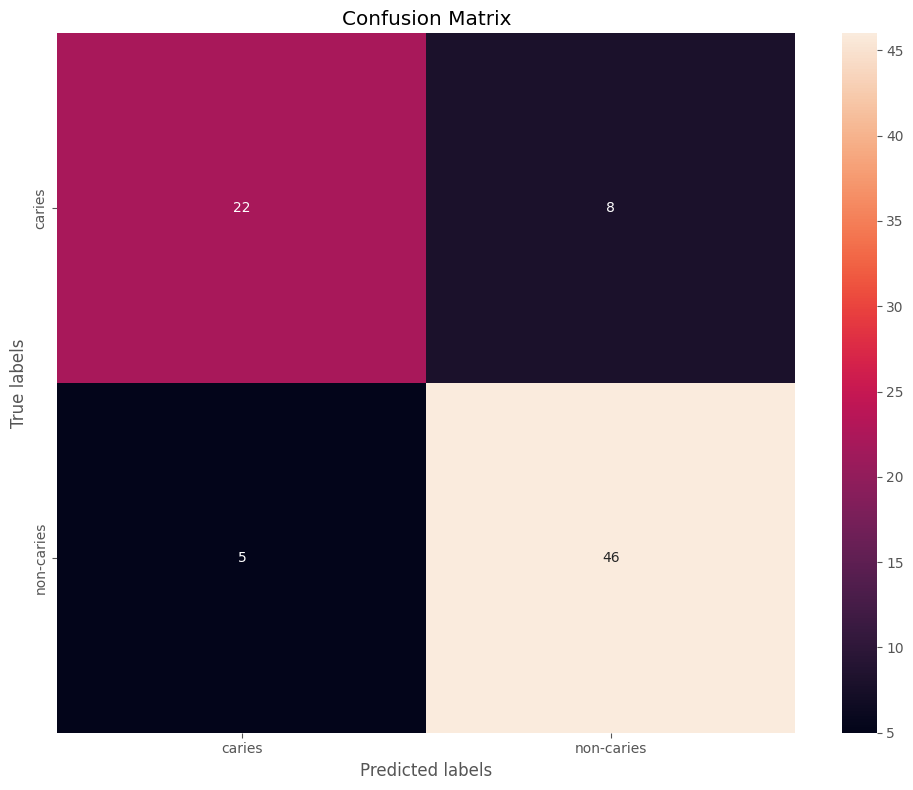

Precision: 0.8519
Recall: 0.9020
F1 Score: 0.8762
FPR: 0.0000
TPR: 0.0196
AUC: 0.8967
Metrics saved to DataFrame.
                      Model Name Epochs  Test Accuracy  Precision    Recall  \
0                vit_b_32_caries     15       0.679012   0.727273  0.784314   
1            vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                vit_b_16_caries     22       0.691358   0.671053  1.000000   
3            vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4      mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5  mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6             densenet121_caries     12       0.839506   0.851852  0.901961   

   F1 Score       FPR       TPR       AUC  
0  0.754717  0.000000  0.019608  0.781699  
1  0.955224  0.000000  0.029412  0.986520  
2  0.803150  0.000000  0.019608  0.768627  
3  0.985075  0.000000  0.029412  1.000000  
4  0.784615  0.033333  0.196078  

100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Epoch 1/30, Loss: 0.4729


100%|██████████| 2/2 [00:00<00:00,  7.02it/s]


Validation Accuracy after Epoch 1: 0.4348 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Epoch 2/30, Loss: 0.1730


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Validation Accuracy after Epoch 2: 0.9565 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


Epoch 3/30, Loss: 0.2025


100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


Validation Accuracy after Epoch 3: 0.6522 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Epoch 4/30, Loss: 0.1317


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Validation Accuracy after Epoch 4: 0.8478 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


Epoch 5/30, Loss: 0.0802


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Validation Accuracy after Epoch 5: 0.8478 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


Epoch 6/30, Loss: 0.0453


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Validation Accuracy after Epoch 6: 1.0000 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Epoch 7/30, Loss: 0.0311


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Validation Accuracy after Epoch 7: 0.9783 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 8/30, Loss: 0.0792


100%|██████████| 2/2 [00:00<00:00,  7.02it/s]


Validation Accuracy after Epoch 8: 1.0000 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


Epoch 9/30, Loss: 0.0281


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Validation Accuracy after Epoch 9: 0.9348 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


Epoch 10/30, Loss: 0.0490


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Validation Accuracy after Epoch 10: 0.9130 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


Epoch 11/30, Loss: 0.0384


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Validation Accuracy after Epoch 11: 0.9565 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


Epoch 12/30, Loss: 0.0324


100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Validation Accuracy after Epoch 12: 0.9130 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.68it/s]


Epoch 13/30, Loss: 0.0138


100%|██████████| 2/2 [00:00<00:00,  7.43it/s]


Validation Accuracy after Epoch 13: 0.8478 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch 14/30, Loss: 0.0090


100%|██████████| 2/2 [00:00<00:00,  8.07it/s]


Validation Accuracy after Epoch 14: 1.0000 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Epoch 15/30, Loss: 0.0088


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Validation Accuracy after Epoch 15: 0.9565 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


Epoch 16/30, Loss: 0.0064


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Validation Accuracy after Epoch 16: 0.9783 (no improvement)
Early stopping triggered after 16 epochs.
Best model for densenet121_non_caries saved with validation accuracy: 1.0000


100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


Test Accuracy for densenet121_non_caries
Accuracy: 1.0000
Confusion Matrix:
[[24  0]
 [ 0 34]]


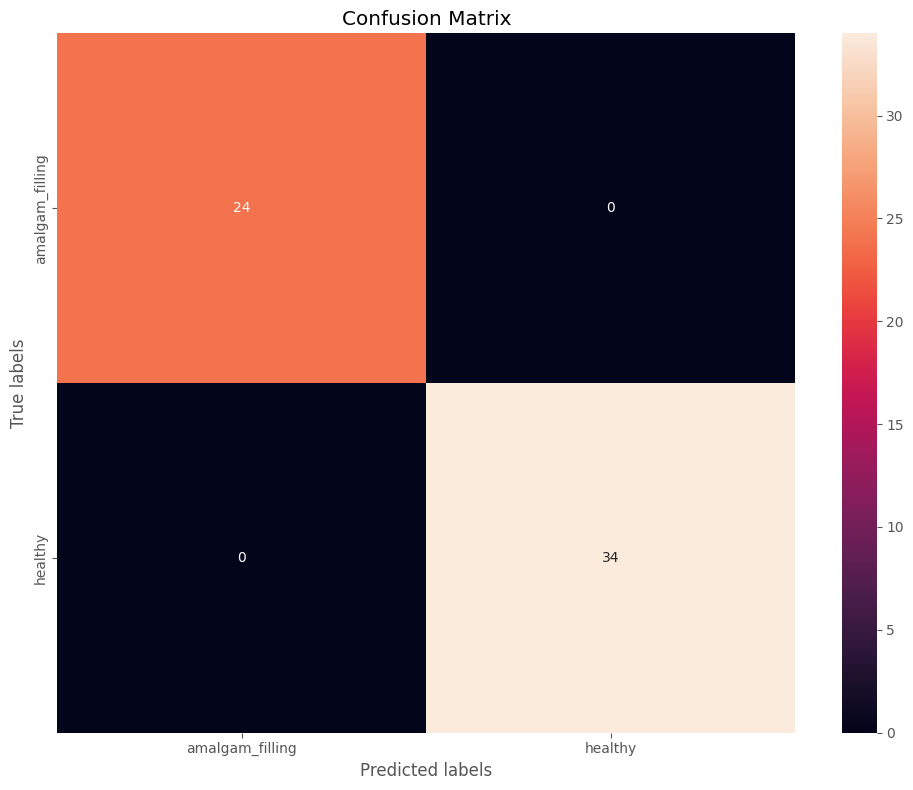

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
FPR: 0.0000
TPR: 0.0294
AUC: 1.0000
Metrics saved to DataFrame.
                      Model Name Epochs  Test Accuracy  Precision    Recall  \
0                vit_b_32_caries     15       0.679012   0.727273  0.784314   
1            vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                vit_b_16_caries     22       0.691358   0.671053  1.000000   
3            vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4      mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5  mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6             densenet121_caries     12       0.839506   0.851852  0.901961   
7         densenet121_non_caries     16       1.000000   1.000000  1.000000   

   F1 Score       FPR       TPR       AUC  
0  0.754717  0.000000  0.019608  0.781699  
1  0.955224  0.000000  0.029412  0.986520  
2  0.803150  0.000000  0.019608  0.768627 

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 172MB/s]


Training model: efficientnet_b4 for Caries Detection


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 1/30, Loss: 0.5824


100%|██████████| 3/3 [00:00<00:00,  6.05it/s]


Validation Accuracy after Epoch 1: 0.7538 (improved)


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Epoch 2/30, Loss: 0.4489


100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


Validation Accuracy after Epoch 2: 0.7538 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Epoch 3/30, Loss: 0.3527


100%|██████████| 3/3 [00:00<00:00,  7.95it/s]


Validation Accuracy after Epoch 3: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Epoch 4/30, Loss: 0.3343


100%|██████████| 3/3 [00:00<00:00,  6.99it/s]


Validation Accuracy after Epoch 4: 0.7692 (improved)


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Epoch 5/30, Loss: 0.2868


100%|██████████| 3/3 [00:00<00:00,  7.91it/s]


Validation Accuracy after Epoch 5: 0.6769 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 6/30, Loss: 0.2676


100%|██████████| 3/3 [00:00<00:00,  8.10it/s]


Validation Accuracy after Epoch 6: 0.6769 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch 7/30, Loss: 0.2146


100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


Validation Accuracy after Epoch 7: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Epoch 8/30, Loss: 0.1476


100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


Validation Accuracy after Epoch 8: 0.7692 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 9/30, Loss: 0.0967


100%|██████████| 3/3 [00:00<00:00,  8.11it/s]


Validation Accuracy after Epoch 9: 0.7846 (improved)


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 10/30, Loss: 0.1061


100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


Validation Accuracy after Epoch 10: 0.8154 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 11/30, Loss: 0.0794


100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


Validation Accuracy after Epoch 11: 0.8154 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 12/30, Loss: 0.1451


100%|██████████| 3/3 [00:00<00:00,  8.07it/s]


Validation Accuracy after Epoch 12: 0.7846 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 13/30, Loss: 0.1141


100%|██████████| 3/3 [00:00<00:00,  8.08it/s]


Validation Accuracy after Epoch 13: 0.7846 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 14/30, Loss: 0.0988


100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


Validation Accuracy after Epoch 14: 0.8462 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 15/30, Loss: 0.1362


100%|██████████| 3/3 [00:00<00:00,  7.92it/s]


Validation Accuracy after Epoch 15: 0.8462 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch 16/30, Loss: 0.0616


100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


Validation Accuracy after Epoch 16: 0.7692 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 17/30, Loss: 0.0756


100%|██████████| 3/3 [00:00<00:00,  8.06it/s]


Validation Accuracy after Epoch 17: 0.8154 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 18/30, Loss: 0.0723


100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


Validation Accuracy after Epoch 18: 0.8000 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 19/30, Loss: 0.0311


100%|██████████| 3/3 [00:00<00:00,  7.99it/s]


Validation Accuracy after Epoch 19: 0.8308 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


Epoch 20/30, Loss: 0.0257


100%|██████████| 3/3 [00:00<00:00,  7.73it/s]


Validation Accuracy after Epoch 20: 0.9231 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Epoch 21/30, Loss: 0.0353


100%|██████████| 3/3 [00:00<00:00,  6.87it/s]


Validation Accuracy after Epoch 21: 0.8615 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 22/30, Loss: 0.0750


100%|██████████| 3/3 [00:00<00:00,  8.08it/s]


Validation Accuracy after Epoch 22: 0.8615 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


Epoch 23/30, Loss: 0.1076


100%|██████████| 3/3 [00:00<00:00,  7.93it/s]


Validation Accuracy after Epoch 23: 0.8615 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


Epoch 24/30, Loss: 0.0556


100%|██████████| 3/3 [00:00<00:00,  6.86it/s]


Validation Accuracy after Epoch 24: 0.7692 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 25/30, Loss: 0.0382


100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


Validation Accuracy after Epoch 25: 0.8308 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Epoch 26/30, Loss: 0.0293


100%|██████████| 3/3 [00:00<00:00,  8.04it/s]


Validation Accuracy after Epoch 26: 0.8000 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch 27/30, Loss: 0.0454


100%|██████████| 3/3 [00:00<00:00,  6.55it/s]


Validation Accuracy after Epoch 27: 0.8462 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch 28/30, Loss: 0.0294


100%|██████████| 3/3 [00:00<00:00,  8.00it/s]


Validation Accuracy after Epoch 28: 0.8615 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Epoch 29/30, Loss: 0.0840


100%|██████████| 3/3 [00:00<00:00,  7.92it/s]


Validation Accuracy after Epoch 29: 0.8462 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch 30/30, Loss: 0.0268


100%|██████████| 3/3 [00:00<00:00,  6.64it/s]


Validation Accuracy after Epoch 30: 0.8615 (no improvement)
Early stopping triggered after 30 epochs.
Best model for efficientnet_b4_caries saved with validation accuracy: 0.9231


100%|██████████| 3/3 [00:00<00:00,  5.55it/s]


Test Accuracy for efficientnet_b4_caries
Accuracy: 0.8025
Confusion Matrix:
[[17 13]
 [ 3 48]]


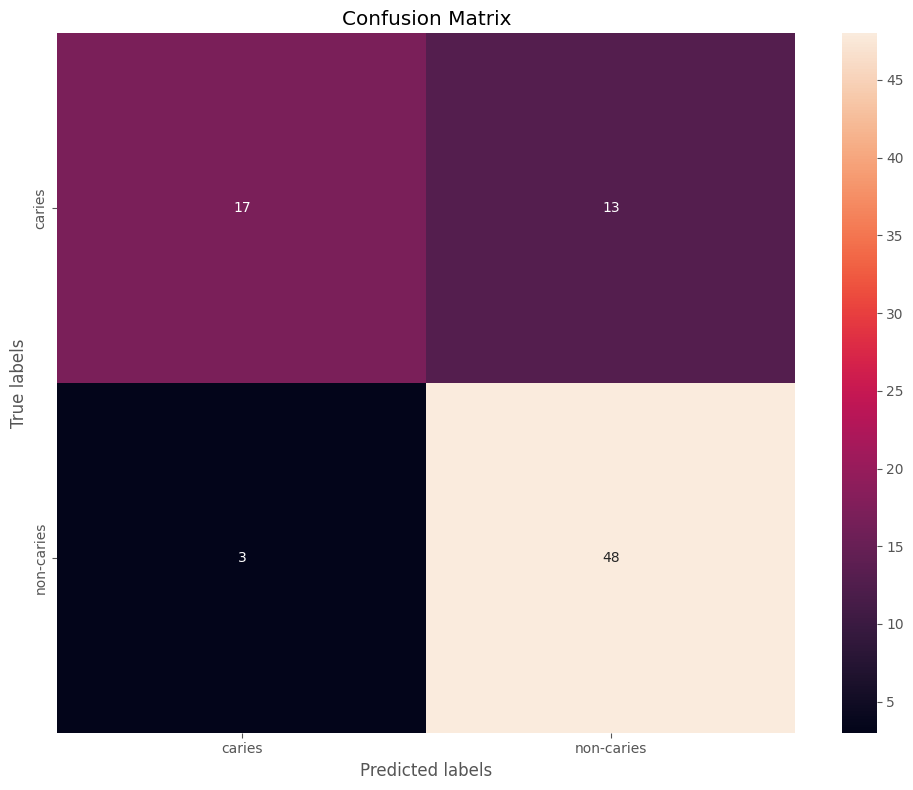

Precision: 0.7869
Recall: 0.9412
F1 Score: 0.8571
FPR: 0.0333
TPR: 0.1373
AUC: 0.8761
Metrics saved to DataFrame.
                      Model Name Epochs  Test Accuracy  Precision    Recall  \
0                vit_b_32_caries     15       0.679012   0.727273  0.784314   
1            vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                vit_b_16_caries     22       0.691358   0.671053  1.000000   
3            vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4      mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5  mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6             densenet121_caries     12       0.839506   0.851852  0.901961   
7         densenet121_non_caries     16       1.000000   1.000000  1.000000   
8         efficientnet_b4_caries     30       0.802469   0.786885  0.941176   

   F1 Score       FPR       TPR       AUC  
0  0.754717  0.000000  0.019608  0.781699  
1  0.95

100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch 1/30, Loss: 0.6483


100%|██████████| 2/2 [00:00<00:00,  7.65it/s]


Validation Accuracy after Epoch 1: 0.7609 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Epoch 2/30, Loss: 0.4533


100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Validation Accuracy after Epoch 2: 0.6087 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch 3/30, Loss: 0.1768


100%|██████████| 2/2 [00:00<00:00,  7.81it/s]


Validation Accuracy after Epoch 3: 0.8043 (improved)


100%|██████████| 6/6 [00:03<00:00,  1.99it/s]


Epoch 4/30, Loss: 0.0745


100%|██████████| 2/2 [00:00<00:00,  7.75it/s]


Validation Accuracy after Epoch 4: 0.9130 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch 5/30, Loss: 0.0277


100%|██████████| 2/2 [00:00<00:00,  7.78it/s]


Validation Accuracy after Epoch 5: 0.8478 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch 6/30, Loss: 0.0218


100%|██████████| 2/2 [00:00<00:00,  7.45it/s]


Validation Accuracy after Epoch 6: 0.9565 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Epoch 7/30, Loss: 0.0135


100%|██████████| 2/2 [00:00<00:00,  7.80it/s]


Validation Accuracy after Epoch 7: 1.0000 (improved)


100%|██████████| 6/6 [00:03<00:00,  1.99it/s]


Epoch 8/30, Loss: 0.0215


100%|██████████| 2/2 [00:00<00:00,  7.75it/s]


Validation Accuracy after Epoch 8: 1.0000 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch 9/30, Loss: 0.0020


100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


Validation Accuracy after Epoch 9: 1.0000 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch 10/30, Loss: 0.0329


100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


Validation Accuracy after Epoch 10: 0.9783 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch 11/30, Loss: 0.0015


100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


Validation Accuracy after Epoch 11: 1.0000 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


Epoch 12/30, Loss: 0.0368


100%|██████████| 2/2 [00:00<00:00,  7.41it/s]


Validation Accuracy after Epoch 12: 0.9783 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch 13/30, Loss: 0.0050


100%|██████████| 2/2 [00:00<00:00,  7.43it/s]


Validation Accuracy after Epoch 13: 0.9783 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch 14/30, Loss: 0.0257


100%|██████████| 2/2 [00:00<00:00,  7.72it/s]


Validation Accuracy after Epoch 14: 1.0000 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch 15/30, Loss: 0.0203


100%|██████████| 2/2 [00:00<00:00,  7.73it/s]


Validation Accuracy after Epoch 15: 1.0000 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  2.00it/s]


Epoch 16/30, Loss: 0.0225


100%|██████████| 2/2 [00:00<00:00,  6.84it/s]


Validation Accuracy after Epoch 16: 1.0000 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch 17/30, Loss: 0.0024


100%|██████████| 2/2 [00:00<00:00,  7.77it/s]


Validation Accuracy after Epoch 17: 1.0000 (no improvement)
Early stopping triggered after 17 epochs.
Best model for efficientnet_b4_non_caries saved with validation accuracy: 1.0000


100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


Test Accuracy for efficientnet_b4_non_caries
Accuracy: 1.0000
Confusion Matrix:
[[24  0]
 [ 0 34]]


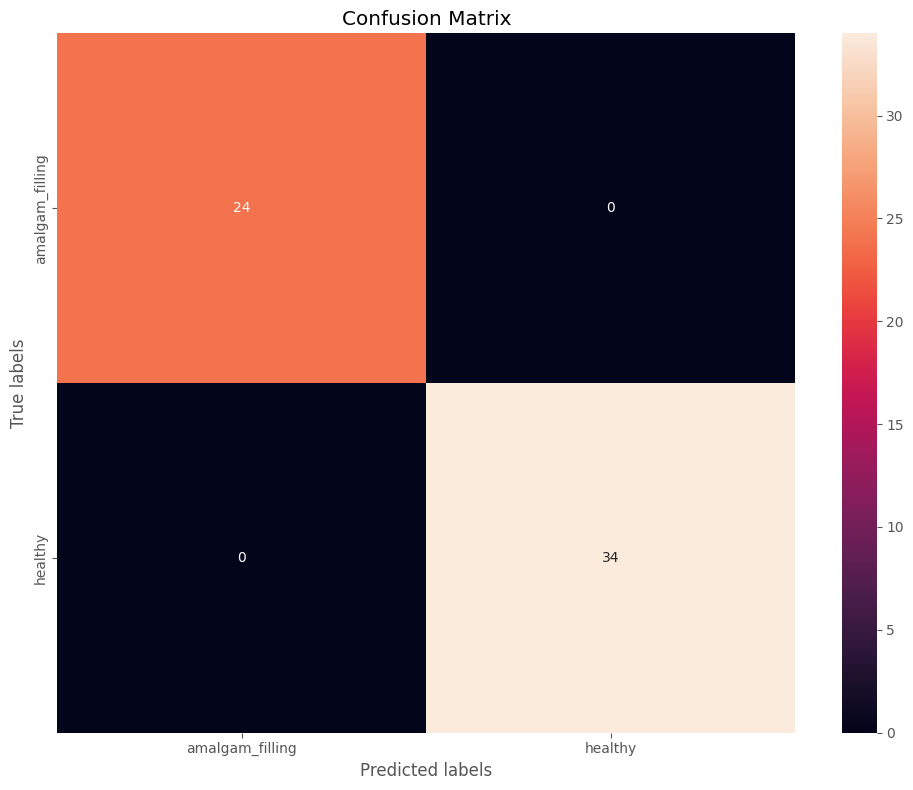

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
FPR: 0.0000
TPR: 0.0294
AUC: 1.0000
Metrics saved to DataFrame.
                      Model Name Epochs  Test Accuracy  Precision    Recall  \
0                vit_b_32_caries     15       0.679012   0.727273  0.784314   
1            vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                vit_b_16_caries     22       0.691358   0.671053  1.000000   
3            vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4      mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5  mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6             densenet121_caries     12       0.839506   0.851852  0.901961   
7         densenet121_non_caries     16       1.000000   1.000000  1.000000   
8         efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9     efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   

   F1 Score     

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 96.0MB/s]


Training model: vgg16 for Caries Detection


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 1/30, Loss: 1.8858


100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


Validation Accuracy after Epoch 1: 0.7538 (improved)


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 2/30, Loss: 0.6983


100%|██████████| 3/3 [00:00<00:00,  6.18it/s]


Validation Accuracy after Epoch 2: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 3/30, Loss: 0.6035


100%|██████████| 3/3 [00:00<00:00,  5.90it/s]


Validation Accuracy after Epoch 3: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 4/30, Loss: 0.6030


100%|██████████| 3/3 [00:00<00:00,  6.15it/s]


Validation Accuracy after Epoch 4: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 5/30, Loss: 0.5919


100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


Validation Accuracy after Epoch 5: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 6/30, Loss: 0.7249


100%|██████████| 3/3 [00:00<00:00,  6.00it/s]


Validation Accuracy after Epoch 6: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 7/30, Loss: 0.5963


100%|██████████| 3/3 [00:00<00:00,  5.95it/s]


Validation Accuracy after Epoch 7: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 8/30, Loss: 0.5890


100%|██████████| 3/3 [00:00<00:00,  5.61it/s]


Validation Accuracy after Epoch 8: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Epoch 9/30, Loss: 0.5882


100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


Validation Accuracy after Epoch 9: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Epoch 10/30, Loss: 0.7259


100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


Validation Accuracy after Epoch 10: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 11/30, Loss: 0.6134


100%|██████████| 3/3 [00:00<00:00,  6.01it/s]


Validation Accuracy after Epoch 11: 0.7538 (no improvement)
Early stopping triggered after 11 epochs.
Best model for vgg16_caries saved with validation accuracy: 0.7538


100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


Test Accuracy for vgg16_caries
Accuracy: 0.6296
Confusion Matrix:
[[ 0 30]
 [ 0 51]]


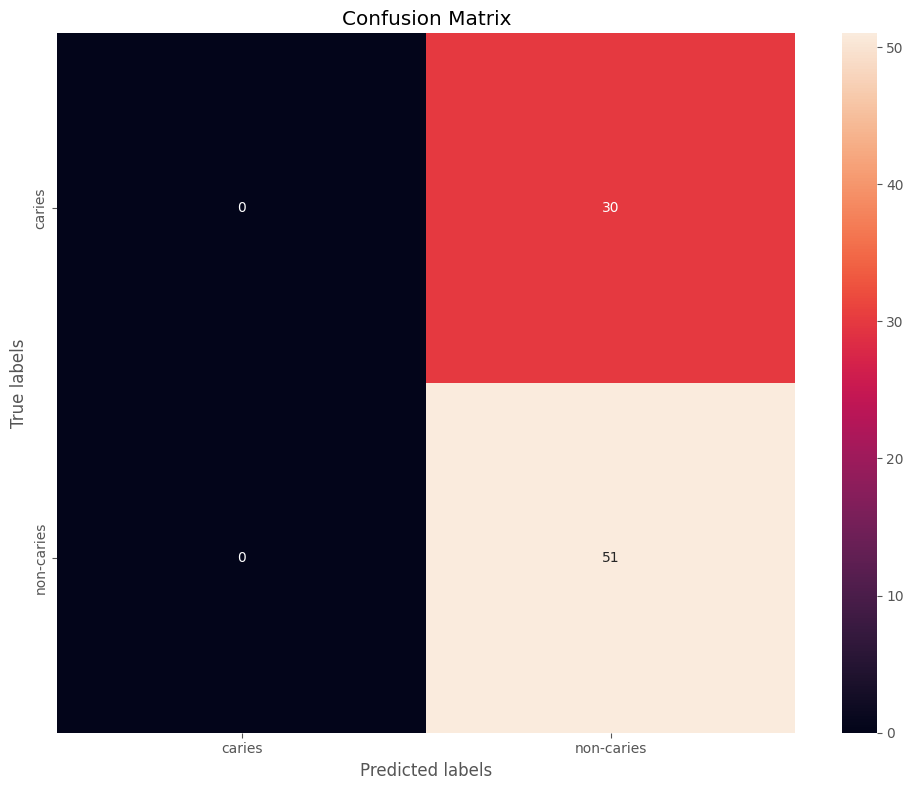

Precision: 0.6296
Recall: 1.0000
F1 Score: 0.7727
FPR: 1.0000
TPR: 1.0000
AUC: 0.5000
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


Epoch 1/30, Loss: 1.3090


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


Validation Accuracy after Epoch 1: 0.5870 (improved)


100%|██████████| 6/6 [00:03<00:00,  1.86it/s]


Epoch 2/30, Loss: 0.9218


100%|██████████| 2/2 [00:00<00:00,  5.03it/s]


Validation Accuracy after Epoch 2: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Epoch 3/30, Loss: 0.7462


100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


Validation Accuracy after Epoch 3: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


Epoch 4/30, Loss: 0.6953


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


Validation Accuracy after Epoch 4: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.87it/s]


Epoch 5/30, Loss: 0.7322


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Validation Accuracy after Epoch 5: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


Epoch 6/30, Loss: 0.6960


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


Validation Accuracy after Epoch 6: 0.5870 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


Epoch 7/30, Loss: 0.6990


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Validation Accuracy after Epoch 7: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


Epoch 8/30, Loss: 0.7134


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Validation Accuracy after Epoch 8: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.87it/s]


Epoch 9/30, Loss: 0.7271


100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


Validation Accuracy after Epoch 9: 0.6087 (improved)


100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


Epoch 10/30, Loss: 0.7885


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Validation Accuracy after Epoch 10: 0.5870 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


Epoch 11/30, Loss: 0.7035


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


Validation Accuracy after Epoch 11: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


Epoch 12/30, Loss: 0.7060


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


Validation Accuracy after Epoch 12: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


Epoch 13/30, Loss: 0.7001


100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


Validation Accuracy after Epoch 13: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


Epoch 14/30, Loss: 0.7054


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


Validation Accuracy after Epoch 14: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


Epoch 15/30, Loss: 0.7057


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Validation Accuracy after Epoch 15: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


Epoch 16/30, Loss: 0.7175


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Validation Accuracy after Epoch 16: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


Epoch 17/30, Loss: 0.7299


100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


Validation Accuracy after Epoch 17: 0.4130 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


Epoch 18/30, Loss: 0.7078


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


Validation Accuracy after Epoch 18: 0.5870 (no improvement)


100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


Epoch 19/30, Loss: 0.7023


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Validation Accuracy after Epoch 19: 0.4130 (no improvement)
Early stopping triggered after 19 epochs.
Best model for vgg16_non_caries saved with validation accuracy: 0.6087


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Test Accuracy for vgg16_non_caries
Accuracy: 0.4138
Confusion Matrix:
[[24  0]
 [34  0]]


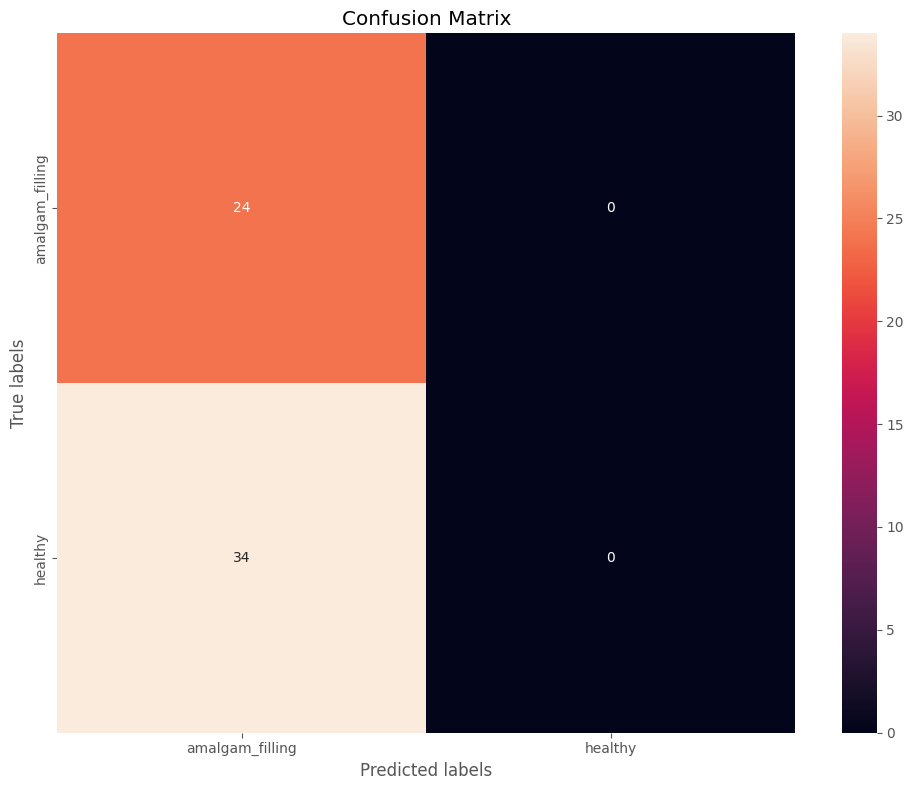

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
FPR: 1.0000
TPR: 1.0000
AUC: 0.5000
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


Training model: resnet50 for Caries Detection


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]


Epoch 1/30, Loss: 0.6424


100%|██████████| 3/3 [00:00<00:00,  6.72it/s]


Validation Accuracy after Epoch 1: 0.7538 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Epoch 2/30, Loss: 0.5017


100%|██████████| 3/3 [00:00<00:00,  9.16it/s]


Validation Accuracy after Epoch 2: 0.7538 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Epoch 3/30, Loss: 0.4539


100%|██████████| 3/3 [00:00<00:00,  8.93it/s]


Validation Accuracy after Epoch 3: 0.7538 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Epoch 4/30, Loss: 0.4516


100%|██████████| 3/3 [00:00<00:00,  8.81it/s]


Validation Accuracy after Epoch 4: 0.7385 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Epoch 5/30, Loss: 0.3833


100%|██████████| 3/3 [00:00<00:00,  9.04it/s]


Validation Accuracy after Epoch 5: 0.7231 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Epoch 6/30, Loss: 0.4094


100%|██████████| 3/3 [00:00<00:00,  8.98it/s]


Validation Accuracy after Epoch 6: 0.8462 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Epoch 7/30, Loss: 0.4407


100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


Validation Accuracy after Epoch 7: 0.7692 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Epoch 8/30, Loss: 0.3981


100%|██████████| 3/3 [00:00<00:00,  7.58it/s]


Validation Accuracy after Epoch 8: 0.8154 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.49it/s]


Epoch 9/30, Loss: 0.4036


100%|██████████| 3/3 [00:00<00:00,  8.96it/s]


Validation Accuracy after Epoch 9: 0.7692 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Epoch 10/30, Loss: 0.3838


100%|██████████| 3/3 [00:00<00:00,  8.94it/s]


Validation Accuracy after Epoch 10: 0.8000 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Epoch 11/30, Loss: 0.3685


100%|██████████| 3/3 [00:00<00:00,  8.84it/s]


Validation Accuracy after Epoch 11: 0.8308 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


Epoch 12/30, Loss: 0.3712


100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


Validation Accuracy after Epoch 12: 0.8154 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Epoch 13/30, Loss: 0.3159


100%|██████████| 3/3 [00:00<00:00,  8.79it/s]


Validation Accuracy after Epoch 13: 0.8000 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


Epoch 14/30, Loss: 0.3979


100%|██████████| 3/3 [00:00<00:00,  9.06it/s]


Validation Accuracy after Epoch 14: 0.7538 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


Epoch 15/30, Loss: 0.3713


100%|██████████| 3/3 [00:00<00:00,  9.05it/s]


Validation Accuracy after Epoch 15: 0.7846 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch 16/30, Loss: 0.3498


100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


Validation Accuracy after Epoch 16: 0.8000 (no improvement)
Early stopping triggered after 16 epochs.
Best model for resnet50_caries saved with validation accuracy: 0.8462


100%|██████████| 3/3 [00:00<00:00,  7.04it/s]


Test Accuracy for resnet50_caries
Accuracy: 0.6914
Confusion Matrix:
[[11 19]
 [ 6 45]]


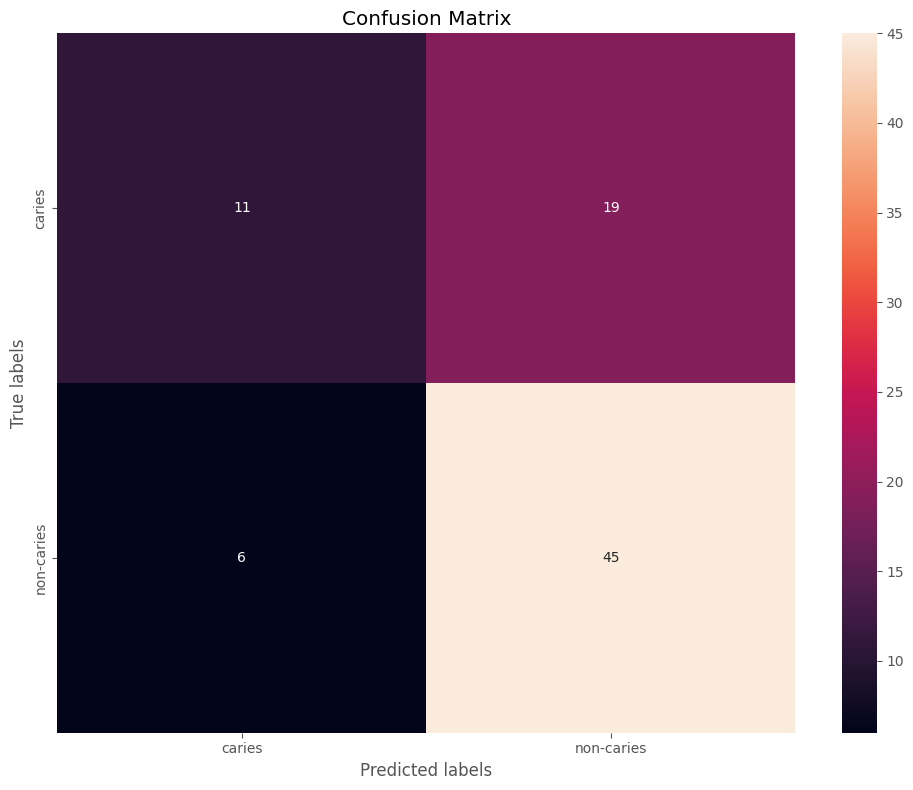

Precision: 0.7031
Recall: 0.8824
F1 Score: 0.7826
FPR: 0.0000
TPR: 0.0196
AUC: 0.7791
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Epoch 1/30, Loss: 0.5533


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Validation Accuracy after Epoch 1: 0.4130 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


Epoch 2/30, Loss: 0.1640


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Validation Accuracy after Epoch 2: 0.4130 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Epoch 3/30, Loss: 0.2512


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Validation Accuracy after Epoch 3: 0.4130 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Epoch 4/30, Loss: 0.2360


100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


Validation Accuracy after Epoch 4: 0.6957 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Epoch 5/30, Loss: 0.1286


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Validation Accuracy after Epoch 5: 0.9783 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Epoch 6/30, Loss: 0.0662


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Validation Accuracy after Epoch 6: 0.8043 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


Epoch 7/30, Loss: 0.0676


100%|██████████| 2/2 [00:00<00:00,  7.88it/s]


Validation Accuracy after Epoch 7: 0.8478 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.68it/s]


Epoch 8/30, Loss: 0.0875


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Validation Accuracy after Epoch 8: 0.7826 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


Epoch 9/30, Loss: 0.1123


100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


Validation Accuracy after Epoch 9: 0.8043 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch 10/30, Loss: 0.0688


100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Validation Accuracy after Epoch 10: 0.8478 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


Epoch 11/30, Loss: 0.0712


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Validation Accuracy after Epoch 11: 0.9130 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Epoch 12/30, Loss: 0.0441


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


Validation Accuracy after Epoch 12: 0.9348 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Epoch 13/30, Loss: 0.1823


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Validation Accuracy after Epoch 13: 0.9565 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Epoch 14/30, Loss: 0.2378


100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


Validation Accuracy after Epoch 14: 0.6739 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch 15/30, Loss: 0.1395


100%|██████████| 2/2 [00:00<00:00,  7.65it/s]


Validation Accuracy after Epoch 15: 0.9348 (no improvement)
Early stopping triggered after 15 epochs.
Best model for resnet50_non_caries saved with validation accuracy: 0.9783


100%|██████████| 2/2 [00:00<00:00,  7.15it/s]


Test Accuracy for resnet50_non_caries
Accuracy: 0.9310
Confusion Matrix:
[[24  0]
 [ 4 30]]


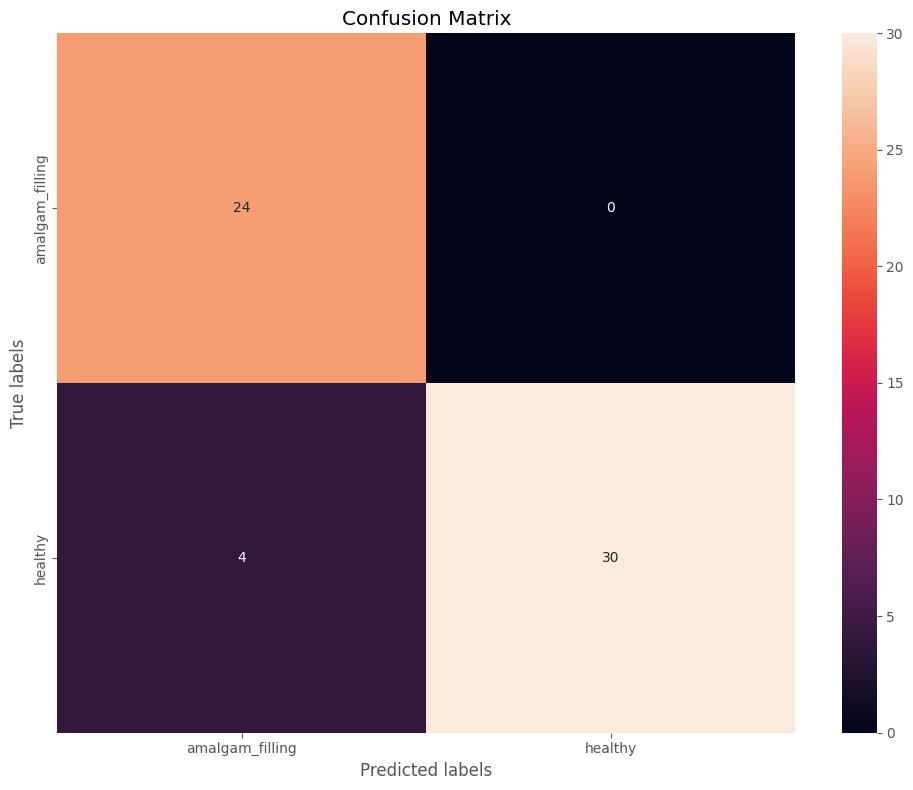

Precision: 1.0000
Recall: 0.8824
F1 Score: 0.9375
FPR: 0.0000
TPR: 0.0294
AUC: 0.9951
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


Training model: resnet18 for Caries Detection


100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Epoch 1/30, Loss: 0.8725


100%|██████████| 3/3 [00:00<00:00, 14.31it/s]


Validation Accuracy after Epoch 1: 0.7846 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.38it/s]


Epoch 2/30, Loss: 0.5283


100%|██████████| 3/3 [00:00<00:00, 14.75it/s]


Validation Accuracy after Epoch 2: 0.7846 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Epoch 3/30, Loss: 0.3797


100%|██████████| 3/3 [00:00<00:00, 14.88it/s]


Validation Accuracy after Epoch 3: 0.8154 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.37it/s]


Epoch 4/30, Loss: 0.3760


100%|██████████| 3/3 [00:00<00:00, 14.59it/s]


Validation Accuracy after Epoch 4: 0.8154 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Epoch 5/30, Loss: 0.3994


100%|██████████| 3/3 [00:00<00:00, 14.68it/s]


Validation Accuracy after Epoch 5: 0.7692 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Epoch 6/30, Loss: 0.3412


100%|██████████| 3/3 [00:00<00:00, 11.54it/s]


Validation Accuracy after Epoch 6: 0.8000 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.47it/s]


Epoch 7/30, Loss: 0.3386


100%|██████████| 3/3 [00:00<00:00, 10.58it/s]


Validation Accuracy after Epoch 7: 0.6769 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.54it/s]


Epoch 8/30, Loss: 0.2521


100%|██████████| 3/3 [00:00<00:00, 14.55it/s]


Validation Accuracy after Epoch 8: 0.8000 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.30it/s]


Epoch 9/30, Loss: 0.3595


100%|██████████| 3/3 [00:00<00:00, 15.03it/s]


Validation Accuracy after Epoch 9: 0.7385 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Epoch 10/30, Loss: 0.3518


100%|██████████| 3/3 [00:00<00:00, 14.69it/s]


Validation Accuracy after Epoch 10: 0.7846 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Epoch 11/30, Loss: 0.3102


100%|██████████| 3/3 [00:00<00:00, 14.84it/s]


Validation Accuracy after Epoch 11: 0.8000 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.41it/s]


Epoch 12/30, Loss: 0.2799


100%|██████████| 3/3 [00:00<00:00, 14.79it/s]


Validation Accuracy after Epoch 12: 0.8154 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


Epoch 13/30, Loss: 0.2626


100%|██████████| 3/3 [00:00<00:00, 14.81it/s]


Validation Accuracy after Epoch 13: 0.8308 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Epoch 14/30, Loss: 0.2121


100%|██████████| 3/3 [00:00<00:00, 13.24it/s]


Validation Accuracy after Epoch 14: 0.7692 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


Epoch 15/30, Loss: 0.2320


100%|██████████| 3/3 [00:00<00:00, 11.97it/s]


Validation Accuracy after Epoch 15: 0.7846 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.42it/s]


Epoch 16/30, Loss: 0.2107


100%|██████████| 3/3 [00:00<00:00, 11.99it/s]


Validation Accuracy after Epoch 16: 0.8000 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Epoch 17/30, Loss: 0.3070


100%|██████████| 3/3 [00:00<00:00, 15.03it/s]


Validation Accuracy after Epoch 17: 0.8462 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.44it/s]


Epoch 18/30, Loss: 0.2839


100%|██████████| 3/3 [00:00<00:00, 14.18it/s]


Validation Accuracy after Epoch 18: 0.8154 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.38it/s]


Epoch 19/30, Loss: 0.2267


100%|██████████| 3/3 [00:00<00:00, 14.50it/s]


Validation Accuracy after Epoch 19: 0.8308 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.31it/s]


Epoch 20/30, Loss: 0.2095


100%|██████████| 3/3 [00:00<00:00, 14.80it/s]


Validation Accuracy after Epoch 20: 0.8000 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.36it/s]


Epoch 21/30, Loss: 0.1958


100%|██████████| 3/3 [00:00<00:00, 14.60it/s]


Validation Accuracy after Epoch 21: 0.8000 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.29it/s]


Epoch 22/30, Loss: 0.2236


100%|██████████| 3/3 [00:00<00:00, 14.79it/s]


Validation Accuracy after Epoch 22: 0.8462 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.34it/s]


Epoch 23/30, Loss: 0.1830


100%|██████████| 3/3 [00:00<00:00, 14.42it/s]


Validation Accuracy after Epoch 23: 0.8462 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


Epoch 24/30, Loss: 0.1997


100%|██████████| 3/3 [00:00<00:00, 11.42it/s]


Validation Accuracy after Epoch 24: 0.8000 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


Epoch 25/30, Loss: 0.1487


100%|██████████| 3/3 [00:00<00:00, 11.87it/s]


Validation Accuracy after Epoch 25: 0.7385 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.38it/s]


Epoch 26/30, Loss: 0.1759


100%|██████████| 3/3 [00:00<00:00, 15.18it/s]


Validation Accuracy after Epoch 26: 0.7846 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.40it/s]


Epoch 27/30, Loss: 0.1516


100%|██████████| 3/3 [00:00<00:00, 14.87it/s]


Validation Accuracy after Epoch 27: 0.7538 (no improvement)
Early stopping triggered after 27 epochs.
Best model for resnet18_caries saved with validation accuracy: 0.8462


100%|██████████| 3/3 [00:00<00:00, 12.55it/s]


Test Accuracy for resnet18_caries
Accuracy: 0.7654
Confusion Matrix:
[[24  6]
 [13 38]]


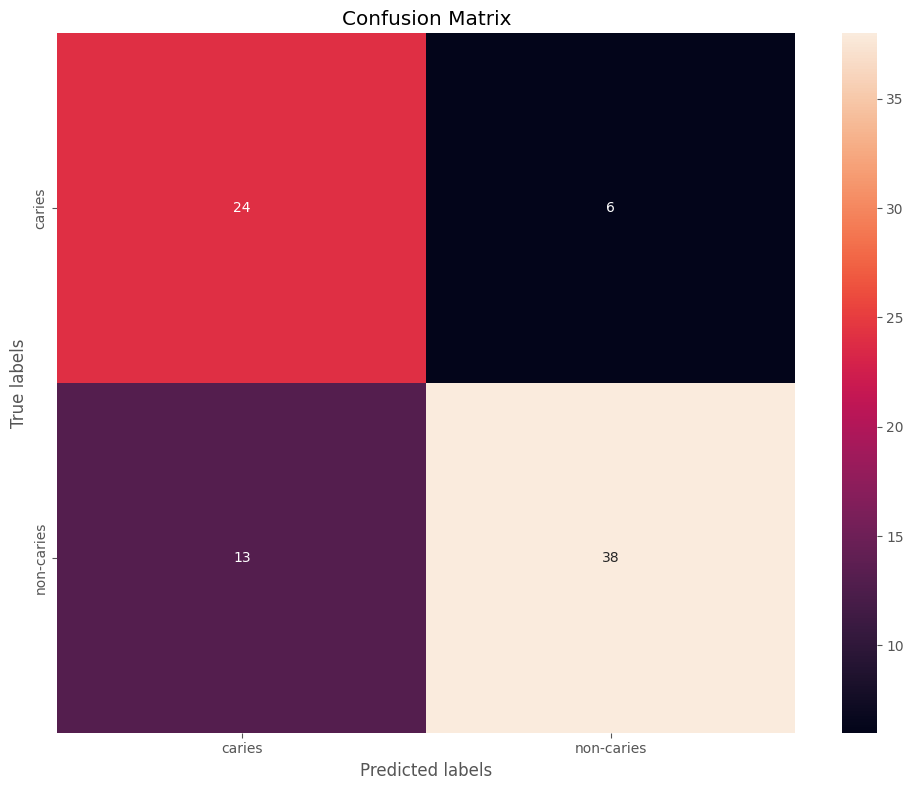

Precision: 0.8636
Recall: 0.7451
F1 Score: 0.8000
FPR: 0.0000
TPR: 0.0588
AUC: 0.8471
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

100%|██████████| 6/6 [00:00<00:00,  6.68it/s]


Epoch 1/30, Loss: 0.3689


100%|██████████| 2/2 [00:00<00:00, 11.70it/s]


Validation Accuracy after Epoch 1: 0.7391 (improved)


100%|██████████| 6/6 [00:00<00:00,  6.55it/s]


Epoch 2/30, Loss: 0.3015


100%|██████████| 2/2 [00:00<00:00, 12.31it/s]


Validation Accuracy after Epoch 2: 0.4130 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.64it/s]


Epoch 3/30, Loss: 0.2213


100%|██████████| 2/2 [00:00<00:00, 12.87it/s]


Validation Accuracy after Epoch 3: 0.5652 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.53it/s]


Epoch 4/30, Loss: 0.0921


100%|██████████| 2/2 [00:00<00:00, 13.53it/s]


Validation Accuracy after Epoch 4: 0.6957 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.60it/s]


Epoch 5/30, Loss: 0.1306


100%|██████████| 2/2 [00:00<00:00, 13.22it/s]


Validation Accuracy after Epoch 5: 0.9130 (improved)


100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


Epoch 6/30, Loss: 0.0760


100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


Validation Accuracy after Epoch 6: 0.9348 (improved)


100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


Epoch 7/30, Loss: 0.0510


100%|██████████| 2/2 [00:00<00:00, 10.78it/s]


Validation Accuracy after Epoch 7: 0.8696 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


Epoch 8/30, Loss: 0.0382


100%|██████████| 2/2 [00:00<00:00, 10.73it/s]


Validation Accuracy after Epoch 8: 0.9348 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


Epoch 9/30, Loss: 0.0408


100%|██████████| 2/2 [00:00<00:00, 13.00it/s]


Validation Accuracy after Epoch 9: 0.9348 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


Epoch 10/30, Loss: 0.0478


100%|██████████| 2/2 [00:00<00:00, 12.53it/s]


Validation Accuracy after Epoch 10: 0.9565 (improved)


100%|██████████| 6/6 [00:00<00:00,  6.61it/s]


Epoch 11/30, Loss: 0.0662


100%|██████████| 2/2 [00:00<00:00, 12.01it/s]


Validation Accuracy after Epoch 11: 0.9565 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.57it/s]


Epoch 12/30, Loss: 0.0218


100%|██████████| 2/2 [00:00<00:00, 12.53it/s]


Validation Accuracy after Epoch 12: 0.9783 (improved)


100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


Epoch 13/30, Loss: 0.0140


100%|██████████| 2/2 [00:00<00:00, 13.27it/s]


Validation Accuracy after Epoch 13: 0.9565 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.57it/s]


Epoch 14/30, Loss: 0.0100


100%|██████████| 2/2 [00:00<00:00, 13.24it/s]


Validation Accuracy after Epoch 14: 0.9565 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.54it/s]


Epoch 15/30, Loss: 0.0099


100%|██████████| 2/2 [00:00<00:00, 13.59it/s]


Validation Accuracy after Epoch 15: 0.9348 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.53it/s]


Epoch 16/30, Loss: 0.0959


100%|██████████| 2/2 [00:00<00:00, 12.88it/s]


Validation Accuracy after Epoch 16: 0.6522 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.58it/s]


Epoch 17/30, Loss: 0.0660


100%|██████████| 2/2 [00:00<00:00, 12.94it/s]


Validation Accuracy after Epoch 17: 0.5652 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


Epoch 18/30, Loss: 0.0288


100%|██████████| 2/2 [00:00<00:00, 10.79it/s]


Validation Accuracy after Epoch 18: 0.7826 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


Epoch 19/30, Loss: 0.0953


100%|██████████| 2/2 [00:00<00:00, 11.33it/s]


Validation Accuracy after Epoch 19: 1.0000 (improved)


100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


Epoch 20/30, Loss: 0.0674


100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


Validation Accuracy after Epoch 20: 1.0000 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


Epoch 21/30, Loss: 0.0508


100%|██████████| 2/2 [00:00<00:00, 12.17it/s]


Validation Accuracy after Epoch 21: 0.9565 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.59it/s]


Epoch 22/30, Loss: 0.0665


100%|██████████| 2/2 [00:00<00:00, 11.99it/s]


Validation Accuracy after Epoch 22: 0.9565 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.58it/s]


Epoch 23/30, Loss: 0.0182


100%|██████████| 2/2 [00:00<00:00, 12.25it/s]


Validation Accuracy after Epoch 23: 0.9565 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.47it/s]


Epoch 24/30, Loss: 0.0365


100%|██████████| 2/2 [00:00<00:00, 11.93it/s]


Validation Accuracy after Epoch 24: 0.9565 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.53it/s]


Epoch 25/30, Loss: 0.0149


100%|██████████| 2/2 [00:00<00:00, 12.79it/s]


Validation Accuracy after Epoch 25: 0.9783 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.44it/s]


Epoch 26/30, Loss: 0.0477


100%|██████████| 2/2 [00:00<00:00, 12.46it/s]


Validation Accuracy after Epoch 26: 0.9130 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.59it/s]


Epoch 27/30, Loss: 0.0110


100%|██████████| 2/2 [00:00<00:00, 13.10it/s]


Validation Accuracy after Epoch 27: 0.9783 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.45it/s]


Epoch 28/30, Loss: 0.0095


100%|██████████| 2/2 [00:00<00:00, 12.83it/s]


Validation Accuracy after Epoch 28: 1.0000 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.58it/s]


Epoch 29/30, Loss: 0.0081


100%|██████████| 2/2 [00:00<00:00, 13.01it/s]


Validation Accuracy after Epoch 29: 0.9565 (no improvement)
Early stopping triggered after 29 epochs.
Best model for resnet18_non_caries saved with validation accuracy: 1.0000


100%|██████████| 2/2 [00:00<00:00, 11.78it/s]


Test Accuracy for resnet18_non_caries
Accuracy: 0.9655
Confusion Matrix:
[[24  0]
 [ 2 32]]


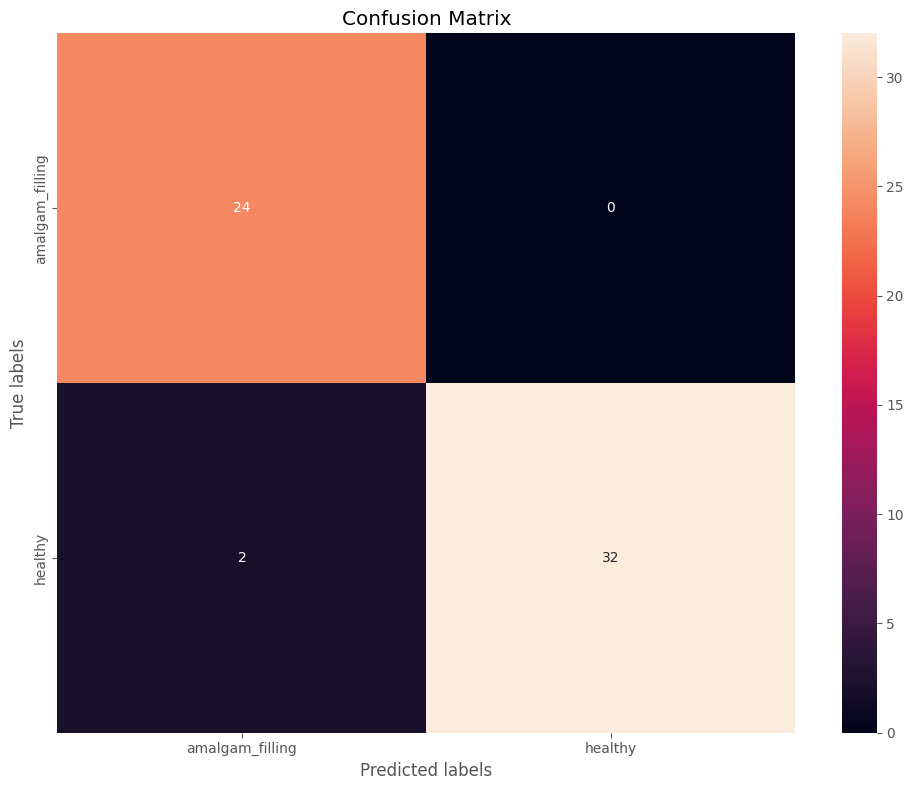

Precision: 1.0000
Recall: 0.9412
F1 Score: 0.9697
FPR: 0.0000
TPR: 0.0294
AUC: 1.0000
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

In [ ]:
if __name__ == '__main__':
    data_dir = '/content/drive/MyDrive/panoramic_data'  # Update this path

    # Step 1: Define class mappings
    folder_to_label_mapping_caries = {'caries': 0, 'amalgam_filling': 1, 'healthy': 1}
    folder_to_label_mapping_non_caries = {'amalgam_filling': 0, 'healthy': 1}

    # Step 2: Load data for both models
    print("Loading data...")
    images_caries, labels_caries = load_data(data_dir, folder_to_label_mapping_caries)
    images_non_caries, labels_non_caries = load_data(data_dir, folder_to_label_mapping_non_caries)

    # Step 3: Split data into train (80%) and test (20%) sets
    print("Splitting data...")
    X_train_caries, X_test_caries, y_train_caries, y_test_caries = train_test_split(images_caries, labels_caries, test_size=0.2, random_state=42)
    X_train_non_caries, X_test_non_caries, y_train_non_caries, y_test_non_caries = train_test_split(images_non_caries, labels_non_caries, test_size=0.2, random_state=42)

    # Step 4: Split train data into train (80%) and validation (20%)
    X_train_caries, X_val_caries, y_train_caries, y_val_caries = train_test_split(X_train_caries, y_train_caries, test_size=0.2, random_state=42)
    X_train_non_caries, X_val_non_caries, y_train_non_caries, y_val_non_caries = train_test_split(X_train_non_caries, y_train_non_caries, test_size=0.2, random_state=42)

    # Step 5: Prepare dataloaders for both models (train, val, and test)
    print("Preparing dataloaders...")
    train_dataset_caries = DentalDataset(X_train_caries, y_train_caries, transform=data_transforms)
    val_dataset_caries = DentalDataset(X_val_caries, y_val_caries, transform=data_transforms)
    test_dataset_caries = DentalDataset(X_test_caries, y_test_caries, transform=data_transforms)

    train_loader_caries = DataLoader(train_dataset_caries, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_caries = DataLoader(val_dataset_caries, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_caries = DataLoader(test_dataset_caries, batch_size=BATCH_SIZE, shuffle=False)

    train_dataset_non_caries = DentalDataset(X_train_non_caries, y_train_non_caries, transform=data_transforms)
    val_dataset_non_caries = DentalDataset(X_val_non_caries, y_val_non_caries, transform=data_transforms)
    test_dataset_non_caries = DentalDataset(X_test_non_caries, y_test_non_caries, transform=data_transforms)

    train_loader_non_caries = DataLoader(train_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_non_caries = DataLoader(val_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_non_caries = DataLoader(test_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=False)

    # Step 6: Train multiple models for both Caries and Non-Caries detection
    models_to_test = [
        'vit_b_32',
        'vit_b_16',
        'mobilenet_v3_large',
        'densenet121',
        'efficientnet_b4',
        'vgg16',
        'resnet50',
        'resnet18',
    ]

    for model_name in models_to_test:
        # Caries Detection Model (2 classes: Caries and Non-Caries)
        model_caries = build_pretrained_model(model_name, 2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_caries.parameters(), lr=LEARNING_RATE)
        print(f"Training model: {model_name} for Caries Detection")
        train_model(model_caries, train_loader_caries, val_loader_caries, test_loader_caries, criterion, optimizer, model_name + "_caries", ['caries', 'non-caries'])
        del model_caries
        torch.cuda.empty_cache()
        gc.collect()

        # Non-Caries Detection Model (2 classes: Amalgam and Normal)
        model_non_caries = build_pretrained_model(model_name, 2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_non_caries.parameters(), lr=LEARNING_RATE)
        print(f"Training model: {model_name} for Non-Caries Detection")
        train_model(model_non_caries, train_loader_non_caries, val_loader_non_caries, test_loader_non_caries, criterion, optimizer, model_name + "_non_caries", ['amalgam_filling', 'healthy'])
        del model_non_caries
        torch.cuda.empty_cache()
        gc.collect()

Loading data...
Splitting data...
Preparing dataloaders...
Training model: densenet121 for Caries Detection


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Epoch 1/30, Loss: 0.5782


100%|██████████| 3/3 [00:00<00:00,  8.93it/s]


Validation Accuracy after Epoch 1: 0.7538 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch 2/30, Loss: 0.4498


100%|██████████| 3/3 [00:00<00:00,  8.90it/s]


Validation Accuracy after Epoch 2: 0.8000 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]


Epoch 3/30, Loss: 0.3812


100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


Validation Accuracy after Epoch 3: 0.8000 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Epoch 4/30, Loss: 0.3883


100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


Validation Accuracy after Epoch 4: 0.8308 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


Epoch 5/30, Loss: 0.3505


100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


Validation Accuracy after Epoch 5: 0.7846 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Epoch 6/30, Loss: 0.2888


100%|██████████| 3/3 [00:00<00:00,  9.00it/s]


Validation Accuracy after Epoch 6: 0.7538 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Epoch 7/30, Loss: 0.3026


100%|██████████| 3/3 [00:00<00:00,  8.95it/s]


Validation Accuracy after Epoch 7: 0.7692 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Epoch 8/30, Loss: 0.3011


100%|██████████| 3/3 [00:00<00:00,  8.91it/s]


Validation Accuracy after Epoch 8: 0.8154 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Epoch 9/30, Loss: 0.2513


100%|██████████| 3/3 [00:00<00:00,  7.49it/s]


Validation Accuracy after Epoch 9: 0.7692 (no improvement)
Early stopping triggered after 9 epochs.
Best model for densenet121_caries saved with validation accuracy: 0.8308


100%|██████████| 3/3 [00:00<00:00,  6.29it/s]


Test Accuracy for densenet121_caries
Accuracy: 0.7531
Confusion Matrix:
[[19 11]
 [ 9 42]]


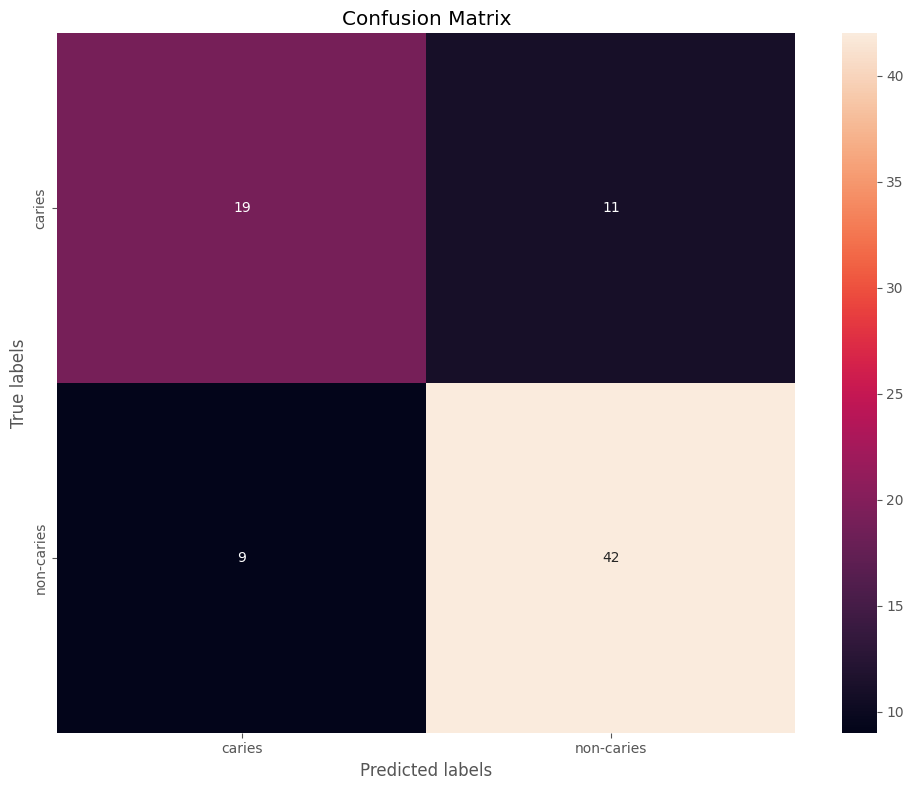

Precision: 0.7925
Recall: 0.8235
F1 Score: 0.8077
FPR: 0.0000
TPR: 0.0196
AUC: 0.8170
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


Epoch 1/30, Loss: 0.4267


100%|██████████| 2/2 [00:00<00:00,  8.82it/s]


Validation Accuracy after Epoch 1: 0.4130 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


Epoch 2/30, Loss: 0.1413


100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


Validation Accuracy after Epoch 2: 0.4130 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


Epoch 3/30, Loss: 0.1192


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Validation Accuracy after Epoch 3: 0.4783 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


Epoch 4/30, Loss: 0.0860


100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


Validation Accuracy after Epoch 4: 0.5435 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


Epoch 5/30, Loss: 0.0962


100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


Validation Accuracy after Epoch 5: 0.6957 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


Epoch 6/30, Loss: 0.0847


100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Validation Accuracy after Epoch 6: 0.9783 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


Epoch 7/30, Loss: 0.1019


100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Validation Accuracy after Epoch 7: 0.8913 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


Epoch 8/30, Loss: 0.0430


100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


Validation Accuracy after Epoch 8: 0.7391 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


Epoch 9/30, Loss: 0.0712


100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


Validation Accuracy after Epoch 9: 0.7174 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


Epoch 10/30, Loss: 0.0554


100%|██████████| 2/2 [00:00<00:00,  7.41it/s]


Validation Accuracy after Epoch 10: 0.9783 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.68it/s]


Epoch 11/30, Loss: 0.0449


100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Validation Accuracy after Epoch 11: 0.8913 (no improvement)
Early stopping triggered after 11 epochs.
Best model for densenet121_non_caries saved with validation accuracy: 0.9783


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


Test Accuracy for densenet121_non_caries
Accuracy: 0.9310
Confusion Matrix:
[[20  4]
 [ 0 34]]


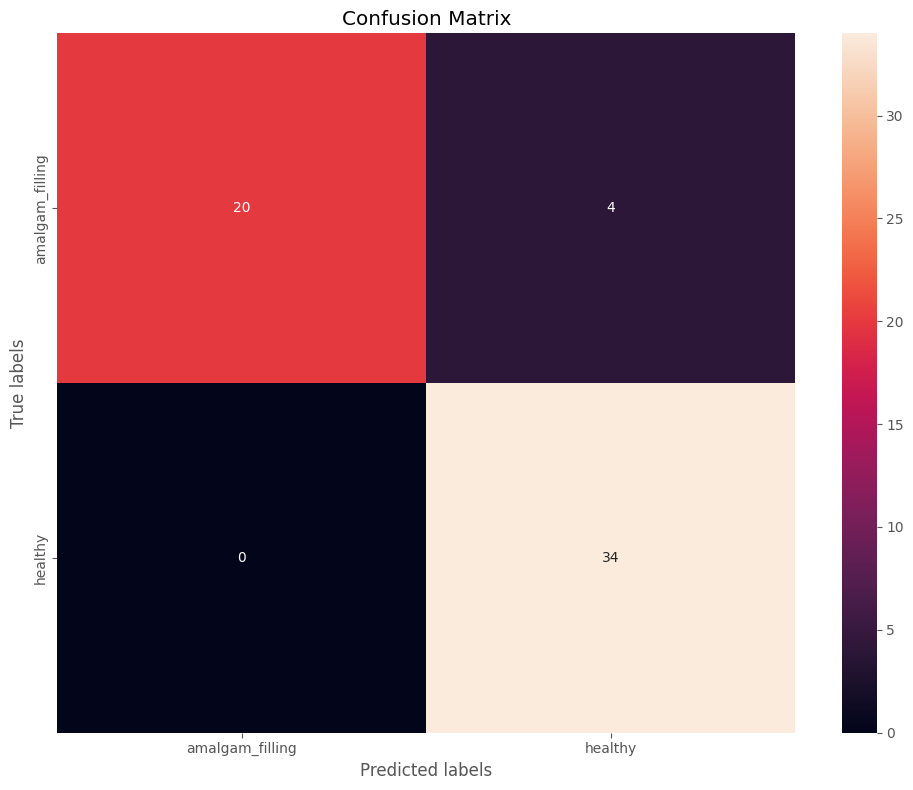

Precision: 0.8947
Recall: 1.0000
F1 Score: 0.9444
FPR: 0.0000
TPR: 0.0294
AUC: 0.9988
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


Epoch 1/30, Loss: 0.5939


100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


Validation Accuracy after Epoch 1: 0.7538 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Epoch 2/30, Loss: 0.5017


100%|██████████| 3/3 [00:00<00:00,  6.79it/s]


Validation Accuracy after Epoch 2: 0.7538 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 3/30, Loss: 0.4010


100%|██████████| 3/3 [00:00<00:00,  8.47it/s]


Validation Accuracy after Epoch 3: 0.7846 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


Epoch 4/30, Loss: 0.3049


100%|██████████| 3/3 [00:00<00:00,  8.43it/s]


Validation Accuracy after Epoch 4: 0.7692 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


Epoch 5/30, Loss: 0.2586


100%|██████████| 3/3 [00:00<00:00,  6.98it/s]


Validation Accuracy after Epoch 5: 0.7538 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Epoch 6/30, Loss: 0.2351


100%|██████████| 3/3 [00:00<00:00,  8.42it/s]


Validation Accuracy after Epoch 6: 0.8462 (improved)


100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


Epoch 7/30, Loss: 0.2440


100%|██████████| 3/3 [00:00<00:00,  8.40it/s]


Validation Accuracy after Epoch 7: 0.8154 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch 8/30, Loss: 0.1592


100%|██████████| 3/3 [00:00<00:00,  7.00it/s]


Validation Accuracy after Epoch 8: 0.7538 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


Epoch 9/30, Loss: 0.1363


100%|██████████| 3/3 [00:00<00:00,  8.02it/s]


Validation Accuracy after Epoch 9: 0.7538 (no improvement)


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 10/30, Loss: 0.1071


100%|██████████| 3/3 [00:00<00:00,  8.20it/s]


Validation Accuracy after Epoch 10: 0.7385 (no improvement)


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch 11/30, Loss: 0.0690


100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Validation Accuracy after Epoch 11: 0.8154 (no improvement)
Early stopping triggered after 11 epochs.
Best model for efficientnet_b4_caries saved with validation accuracy: 0.8462


100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


Test Accuracy for efficientnet_b4_caries
Accuracy: 0.7901
Confusion Matrix:
[[18 12]
 [ 5 46]]


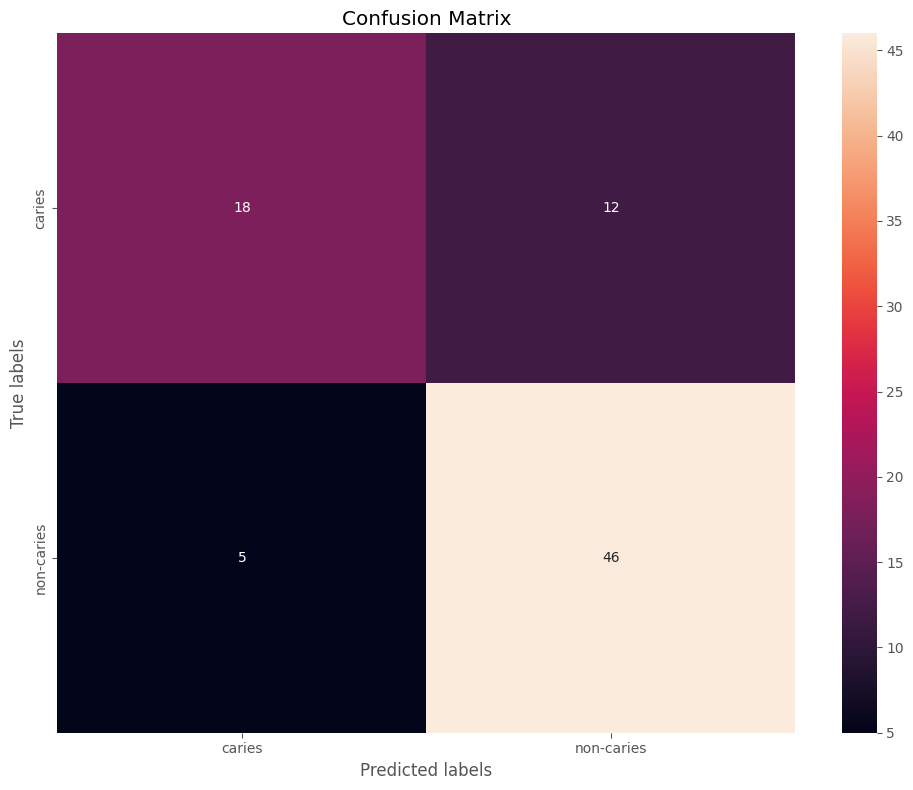

Precision: 0.7931
Recall: 0.9020
F1 Score: 0.8440
FPR: 0.0000
TPR: 0.0980
AUC: 0.8418
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Epoch 1/30, Loss: 0.6575


100%|██████████| 2/2 [00:00<00:00,  7.96it/s]


Validation Accuracy after Epoch 1: 0.5870 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch 2/30, Loss: 0.4297


100%|██████████| 2/2 [00:00<00:00,  7.95it/s]


Validation Accuracy after Epoch 2: 0.7826 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Epoch 3/30, Loss: 0.1839


100%|██████████| 2/2 [00:00<00:00,  7.18it/s]


Validation Accuracy after Epoch 3: 0.9565 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


Epoch 4/30, Loss: 0.0446


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


Validation Accuracy after Epoch 4: 0.8913 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Epoch 5/30, Loss: 0.0384


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Validation Accuracy after Epoch 5: 0.9565 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Epoch 6/30, Loss: 0.0408


100%|██████████| 2/2 [00:00<00:00,  7.97it/s]


Validation Accuracy after Epoch 6: 1.0000 (improved)


100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Epoch 7/30, Loss: 0.0332


100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Validation Accuracy after Epoch 7: 0.9783 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


Epoch 8/30, Loss: 0.0427


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


Validation Accuracy after Epoch 8: 1.0000 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Epoch 9/30, Loss: 0.0260


100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


Validation Accuracy after Epoch 9: 0.9565 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Epoch 10/30, Loss: 0.0172


100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Validation Accuracy after Epoch 10: 0.9783 (no improvement)


100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Epoch 11/30, Loss: 0.0077


100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Validation Accuracy after Epoch 11: 0.9565 (no improvement)
Early stopping triggered after 11 epochs.
Best model for efficientnet_b4_non_caries saved with validation accuracy: 1.0000


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Test Accuracy for efficientnet_b4_non_caries
Accuracy: 0.9828
Confusion Matrix:
[[23  1]
 [ 0 34]]


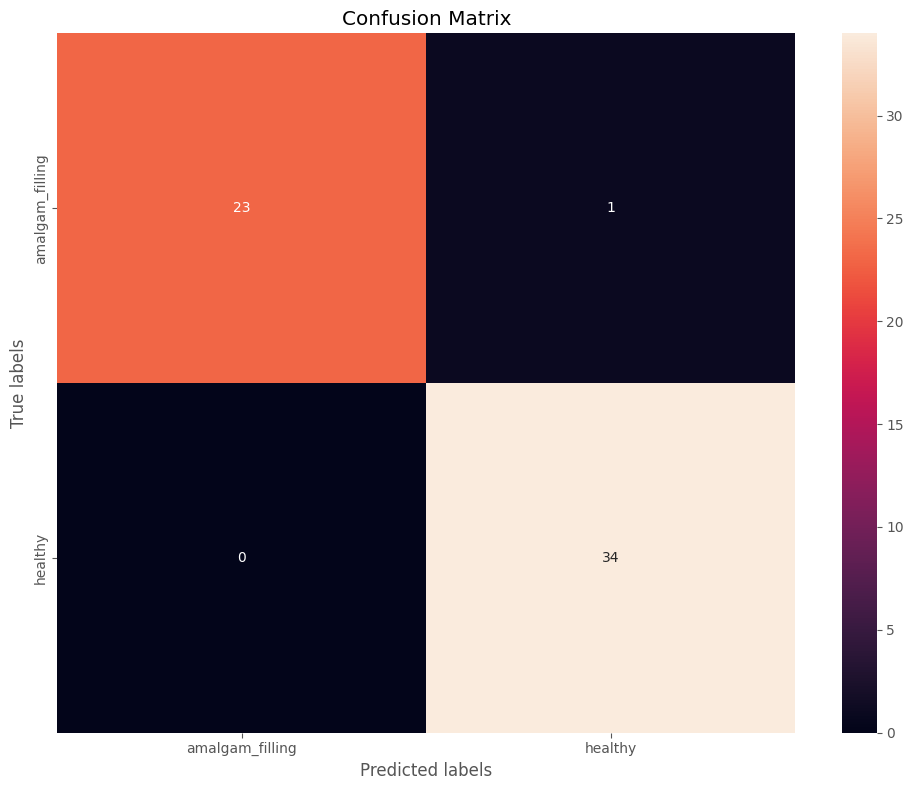

Precision: 0.9714
Recall: 1.0000
F1 Score: 0.9855
FPR: 0.0000
TPR: 0.0294
AUC: 0.9963
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

In [ ]:
if __name__ == '__main__':
    data_dir = '/content/drive/MyDrive/panoramic_data'  # Update this path

    # Step 1: Define class mappings
    folder_to_label_mapping_caries = {'caries': 0, 'amalgam_filling': 1, 'healthy': 1}
    folder_to_label_mapping_non_caries = {'amalgam_filling': 0, 'healthy': 1}

    # Step 2: Load data for both models
    print("Loading data...")
    images_caries, labels_caries = load_data(data_dir, folder_to_label_mapping_caries)
    images_non_caries, labels_non_caries = load_data(data_dir, folder_to_label_mapping_non_caries)

    # Step 3: Split data into train (80%) and test (20%) sets
    print("Splitting data...")
    X_train_caries, X_test_caries, y_train_caries, y_test_caries = train_test_split(images_caries, labels_caries, test_size=0.2, random_state=42)
    X_train_non_caries, X_test_non_caries, y_train_non_caries, y_test_non_caries = train_test_split(images_non_caries, labels_non_caries, test_size=0.2, random_state=42)

    # Step 4: Split train data into train (80%) and validation (20%)
    X_train_caries, X_val_caries, y_train_caries, y_val_caries = train_test_split(X_train_caries, y_train_caries, test_size=0.2, random_state=42)
    X_train_non_caries, X_val_non_caries, y_train_non_caries, y_val_non_caries = train_test_split(X_train_non_caries, y_train_non_caries, test_size=0.2, random_state=42)

    # Step 5: Prepare dataloaders for both models (train, val, and test)
    print("Preparing dataloaders...")
    train_dataset_caries = DentalDataset(X_train_caries, y_train_caries, transform=data_transforms)
    val_dataset_caries = DentalDataset(X_val_caries, y_val_caries, transform=data_transforms)
    test_dataset_caries = DentalDataset(X_test_caries, y_test_caries, transform=data_transforms)

    train_loader_caries = DataLoader(train_dataset_caries, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_caries = DataLoader(val_dataset_caries, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_caries = DataLoader(test_dataset_caries, batch_size=BATCH_SIZE, shuffle=False)

    train_dataset_non_caries = DentalDataset(X_train_non_caries, y_train_non_caries, transform=data_transforms)
    val_dataset_non_caries = DentalDataset(X_val_non_caries, y_val_non_caries, transform=data_transforms)
    test_dataset_non_caries = DentalDataset(X_test_non_caries, y_test_non_caries, transform=data_transforms)

    train_loader_non_caries = DataLoader(train_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_non_caries = DataLoader(val_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_non_caries = DataLoader(test_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=False)

    # Step 6: Train multiple models for both Caries and Non-Caries detection
    models_to_test = [
        'densenet121',
        'efficientnet_b4'
    ]

    for model_name in models_to_test:
        # Caries Detection Model (2 classes: Caries and Non-Caries)
        model_caries = build_pretrained_model(model_name, 2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_caries.parameters(), lr=LEARNING_RATE)
        print(f"Training model: {model_name} for Caries Detection")
        train_model(model_caries, train_loader_caries, val_loader_caries, test_loader_caries, criterion, optimizer, model_name + "_caries", ['caries', 'non-caries'])
        del model_caries
        torch.cuda.empty_cache()
        gc.collect()

        # Non-Caries Detection Model (2 classes: Amalgam and Normal)
        model_non_caries = build_pretrained_model(model_name, 2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_non_caries.parameters(), lr=LEARNING_RATE)
        print(f"Training model: {model_name} for Non-Caries Detection")
        train_model(model_non_caries, train_loader_non_caries, val_loader_non_caries, test_loader_non_caries, criterion, optimizer, model_name + "_non_caries", ['amalgam_filling', 'healthy'])
        del model_non_caries
        torch.cuda.empty_cache()
        gc.collect()

Loading data...
Splitting data...
Preparing dataloaders...
Training model: mobilenet_v3_large for Caries Detection


100%|██████████| 8/8 [00:01<00:00,  6.43it/s]


Epoch 1/30, Loss: 0.7328


100%|██████████| 3/3 [00:00<00:00, 15.96it/s]


Validation Accuracy after Epoch 1: 0.4615 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.81it/s]


Epoch 2/30, Loss: 0.4498


100%|██████████| 3/3 [00:00<00:00, 16.96it/s]


Validation Accuracy after Epoch 2: 0.7077 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.88it/s]


Epoch 3/30, Loss: 0.4556


100%|██████████| 3/3 [00:00<00:00, 16.97it/s]


Validation Accuracy after Epoch 3: 0.6615 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.76it/s]


Epoch 4/30, Loss: 0.3226


100%|██████████| 3/3 [00:00<00:00, 16.13it/s]


Validation Accuracy after Epoch 4: 0.7231 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.81it/s]


Epoch 5/30, Loss: 0.2331


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


Validation Accuracy after Epoch 5: 0.5846 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.82it/s]


Epoch 6/30, Loss: 0.2551


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


Validation Accuracy after Epoch 6: 0.8154 (improved)


100%|██████████| 8/8 [00:01<00:00,  6.75it/s]


Epoch 7/30, Loss: 0.2535


100%|██████████| 3/3 [00:00<00:00, 14.44it/s]


Validation Accuracy after Epoch 7: 0.3385 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Epoch 8/30, Loss: 0.3250


100%|██████████| 3/3 [00:00<00:00, 12.41it/s]


Validation Accuracy after Epoch 8: 0.6615 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.73it/s]


Epoch 9/30, Loss: 0.1946


100%|██████████| 3/3 [00:00<00:00, 16.77it/s]


Validation Accuracy after Epoch 9: 0.6154 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.74it/s]


Epoch 10/30, Loss: 0.1809


100%|██████████| 3/3 [00:00<00:00, 16.90it/s]


Validation Accuracy after Epoch 10: 0.8154 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.72it/s]


Epoch 11/30, Loss: 0.0712


100%|██████████| 3/3 [00:00<00:00, 16.01it/s]


Validation Accuracy after Epoch 11: 0.8000 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.69it/s]


Epoch 12/30, Loss: 0.0723


100%|██████████| 3/3 [00:00<00:00, 16.93it/s]


Validation Accuracy after Epoch 12: 0.8000 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.75it/s]


Epoch 13/30, Loss: 0.0725


100%|██████████| 3/3 [00:00<00:00, 16.53it/s]


Validation Accuracy after Epoch 13: 0.7231 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.68it/s]


Epoch 14/30, Loss: 0.1648


100%|██████████| 3/3 [00:00<00:00, 15.31it/s]


Validation Accuracy after Epoch 14: 0.6923 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.78it/s]


Epoch 15/30, Loss: 0.1433


100%|██████████| 3/3 [00:00<00:00, 17.30it/s]


Validation Accuracy after Epoch 15: 0.7077 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.71it/s]


Epoch 16/30, Loss: 0.1071


100%|██████████| 3/3 [00:00<00:00, 13.24it/s]


Validation Accuracy after Epoch 16: 0.7077 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.56it/s]


Epoch 17/30, Loss: 0.0866


100%|██████████| 3/3 [00:00<00:00, 12.10it/s]


Validation Accuracy after Epoch 17: 0.7077 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.81it/s]


Epoch 18/30, Loss: 0.0746


100%|██████████| 3/3 [00:00<00:00, 15.92it/s]


Validation Accuracy after Epoch 18: 0.7846 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.61it/s]


Epoch 19/30, Loss: 0.0459


100%|██████████| 3/3 [00:00<00:00, 16.87it/s]


Validation Accuracy after Epoch 19: 0.7538 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.74it/s]


Epoch 20/30, Loss: 0.0904


100%|██████████| 3/3 [00:00<00:00, 16.72it/s]


Validation Accuracy after Epoch 20: 0.7538 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.78it/s]


Epoch 21/30, Loss: 0.0575


100%|██████████| 3/3 [00:00<00:00, 16.21it/s]


Validation Accuracy after Epoch 21: 0.5385 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.72it/s]


Epoch 22/30, Loss: 0.0990


100%|██████████| 3/3 [00:00<00:00, 17.12it/s]


Validation Accuracy after Epoch 22: 0.7538 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.71it/s]


Epoch 23/30, Loss: 0.0581


100%|██████████| 3/3 [00:00<00:00, 16.72it/s]


Validation Accuracy after Epoch 23: 0.6308 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.74it/s]


Epoch 24/30, Loss: 0.0415


100%|██████████| 3/3 [00:00<00:00, 16.48it/s]


Validation Accuracy after Epoch 24: 0.7538 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  6.79it/s]


Epoch 25/30, Loss: 0.0482


100%|██████████| 3/3 [00:00<00:00, 12.41it/s]


Validation Accuracy after Epoch 25: 0.5692 (no improvement)


100%|██████████| 8/8 [00:01<00:00,  5.66it/s]


Epoch 26/30, Loss: 0.0394


100%|██████████| 3/3 [00:00<00:00, 12.03it/s]


Validation Accuracy after Epoch 26: 0.7846 (no improvement)
Early stopping triggered after 26 epochs.
Best model for mobilenet_v3_large_caries saved with validation accuracy: 0.8154


100%|██████████| 3/3 [00:00<00:00, 10.56it/s]


Test Accuracy for mobilenet_v3_large_caries
Accuracy: 0.7407
Confusion Matrix:
[[15 15]
 [ 6 45]]


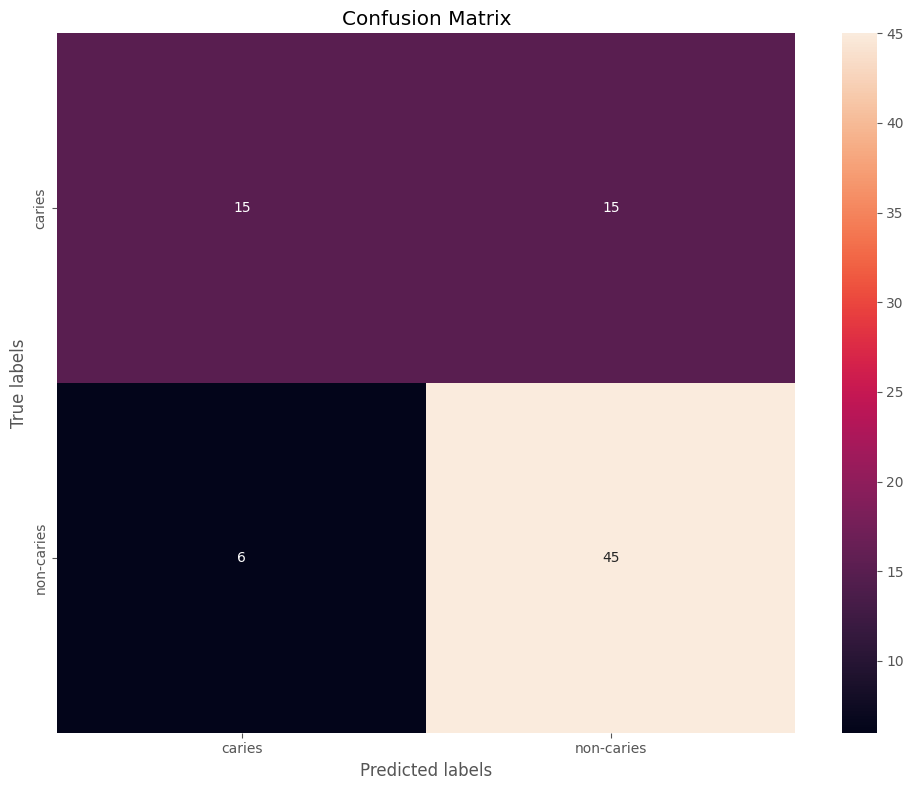

Precision: 0.7500
Recall: 0.8824
F1 Score: 0.8108
FPR: 0.0000
TPR: 0.0196
AUC: 0.7719
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

100%|██████████| 6/6 [00:00<00:00,  6.93it/s]


Epoch 1/30, Loss: 0.5147


100%|██████████| 2/2 [00:00<00:00, 16.50it/s]


Validation Accuracy after Epoch 1: 0.9348 (improved)


100%|██████████| 6/6 [00:00<00:00,  6.92it/s]


Epoch 2/30, Loss: 0.0917


100%|██████████| 2/2 [00:00<00:00, 16.08it/s]


Validation Accuracy after Epoch 2: 0.8913 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.98it/s]


Epoch 3/30, Loss: 0.0430


100%|██████████| 2/2 [00:00<00:00, 16.02it/s]


Validation Accuracy after Epoch 3: 0.7826 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.93it/s]


Epoch 4/30, Loss: 0.0580


100%|██████████| 2/2 [00:00<00:00, 15.35it/s]


Validation Accuracy after Epoch 4: 0.8696 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.96it/s]


Epoch 5/30, Loss: 0.0827


100%|██████████| 2/2 [00:00<00:00, 15.11it/s]


Validation Accuracy after Epoch 5: 0.8696 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.97it/s]


Epoch 6/30, Loss: 0.0115


100%|██████████| 2/2 [00:00<00:00, 15.34it/s]


Validation Accuracy after Epoch 6: 0.9130 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.08it/s]


Epoch 7/30, Loss: 0.0154


100%|██████████| 2/2 [00:00<00:00, 16.30it/s]


Validation Accuracy after Epoch 7: 0.9783 (improved)


100%|██████████| 6/6 [00:00<00:00,  7.04it/s]


Epoch 8/30, Loss: 0.0686


100%|██████████| 2/2 [00:00<00:00, 15.11it/s]


Validation Accuracy after Epoch 8: 0.9130 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.05it/s]


Epoch 9/30, Loss: 0.0456


100%|██████████| 2/2 [00:00<00:00, 16.21it/s]


Validation Accuracy after Epoch 9: 0.9348 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.09it/s]


Epoch 10/30, Loss: 0.0186


100%|██████████| 2/2 [00:00<00:00, 13.29it/s]


Validation Accuracy after Epoch 10: 0.9348 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


Epoch 11/30, Loss: 0.0092


100%|██████████| 2/2 [00:00<00:00, 10.76it/s]


Validation Accuracy after Epoch 11: 0.9348 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


Epoch 12/30, Loss: 0.0070


100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


Validation Accuracy after Epoch 12: 0.9130 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


Epoch 13/30, Loss: 0.0008


100%|██████████| 2/2 [00:00<00:00, 16.45it/s]


Validation Accuracy after Epoch 13: 0.9348 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.01it/s]


Epoch 14/30, Loss: 0.0012


100%|██████████| 2/2 [00:00<00:00, 16.77it/s]


Validation Accuracy after Epoch 14: 0.9348 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.94it/s]


Epoch 15/30, Loss: 0.0022


100%|██████████| 2/2 [00:00<00:00, 16.25it/s]


Validation Accuracy after Epoch 15: 0.9565 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.00it/s]


Epoch 16/30, Loss: 0.0056


100%|██████████| 2/2 [00:00<00:00, 14.88it/s]


Validation Accuracy after Epoch 16: 1.0000 (improved)


100%|██████████| 6/6 [00:00<00:00,  7.06it/s]


Epoch 17/30, Loss: 0.0053


100%|██████████| 2/2 [00:00<00:00, 16.48it/s]


Validation Accuracy after Epoch 17: 0.9348 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.99it/s]


Epoch 18/30, Loss: 0.0635


100%|██████████| 2/2 [00:00<00:00, 13.84it/s]


Validation Accuracy after Epoch 18: 1.0000 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.96it/s]


Epoch 19/30, Loss: 0.0314


100%|██████████| 2/2 [00:00<00:00, 15.71it/s]


Validation Accuracy after Epoch 19: 0.8913 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.98it/s]


Epoch 20/30, Loss: 0.0282


100%|██████████| 2/2 [00:00<00:00, 16.35it/s]


Validation Accuracy after Epoch 20: 0.9130 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.93it/s]


Epoch 21/30, Loss: 0.0008


100%|██████████| 2/2 [00:00<00:00, 16.15it/s]


Validation Accuracy after Epoch 21: 0.7391 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.00it/s]


Epoch 22/30, Loss: 0.0394


100%|██████████| 2/2 [00:00<00:00, 16.37it/s]


Validation Accuracy after Epoch 22: 0.7609 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


Epoch 23/30, Loss: 0.0548


100%|██████████| 2/2 [00:00<00:00, 11.59it/s]


Validation Accuracy after Epoch 23: 0.8913 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


Epoch 24/30, Loss: 0.0247


100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


Validation Accuracy after Epoch 24: 0.8696 (no improvement)


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


Epoch 25/30, Loss: 0.0137


100%|██████████| 2/2 [00:00<00:00, 15.51it/s]


Validation Accuracy after Epoch 25: 0.6739 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.04it/s]


Epoch 26/30, Loss: 0.0049


100%|██████████| 2/2 [00:00<00:00, 15.72it/s]


Validation Accuracy after Epoch 26: 0.6957 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.04it/s]


Epoch 27/30, Loss: 0.0038


100%|██████████| 2/2 [00:00<00:00, 15.92it/s]


Validation Accuracy after Epoch 27: 0.7391 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.04it/s]


Epoch 28/30, Loss: 0.0002


100%|██████████| 2/2 [00:00<00:00, 15.77it/s]


Validation Accuracy after Epoch 28: 0.7609 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


Epoch 29/30, Loss: 0.0011


100%|██████████| 2/2 [00:00<00:00, 16.09it/s]


Validation Accuracy after Epoch 29: 0.7609 (no improvement)


100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Epoch 30/30, Loss: 0.0006


100%|██████████| 2/2 [00:00<00:00, 16.10it/s]


Validation Accuracy after Epoch 30: 0.8043 (no improvement)
Best model for mobilenet_v3_large_non_caries saved with validation accuracy: 1.0000


100%|██████████| 2/2 [00:00<00:00, 13.29it/s]


Test Accuracy for mobilenet_v3_large_non_caries
Accuracy: 0.8621
Confusion Matrix:
[[24  0]
 [ 8 26]]


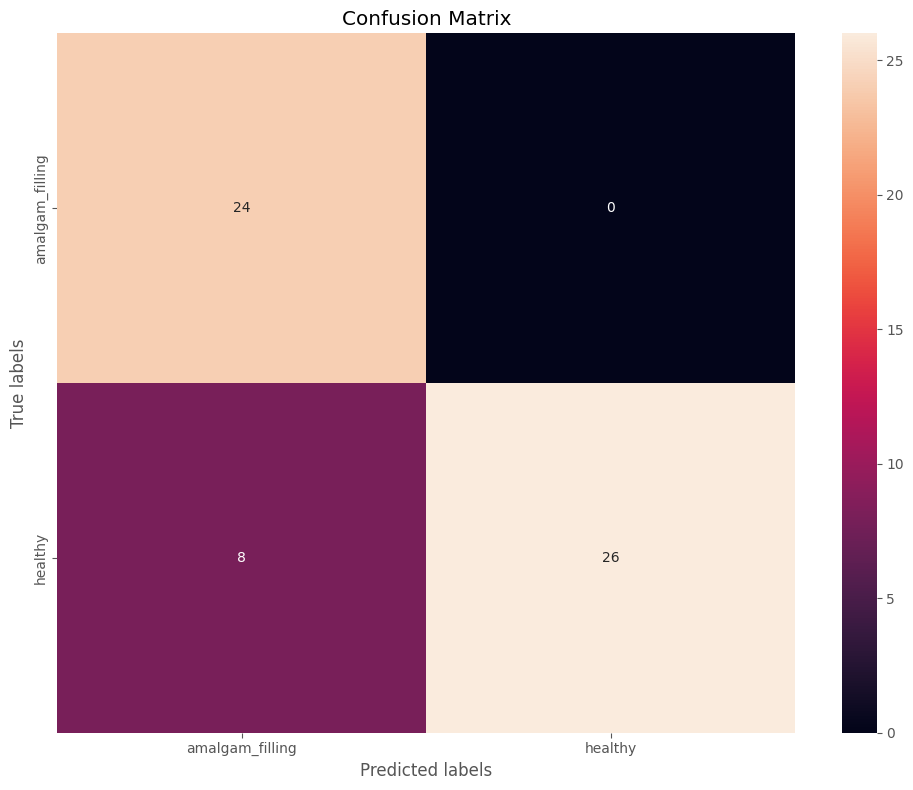

Precision: 1.0000
Recall: 0.7647
F1 Score: 0.8667
FPR: 0.0000
TPR: 0.0294
AUC: 0.9963
Metrics saved to DataFrame.
                       Model Name Epochs  Test Accuracy  Precision    Recall  \
0                 vit_b_32_caries     15       0.679012   0.727273  0.784314   
1             vit_b_32_non_caries     19       0.948276   0.969697  0.941176   
2                 vit_b_16_caries     22       0.691358   0.671053  1.000000   
3             vit_b_16_non_caries     30       0.982759   1.000000  0.970588   
4       mobilenet_v3_large_caries     19       0.654321   0.645570  1.000000   
5   mobilenet_v3_large_non_caries     19       0.775862   0.956522  0.647059   
6              densenet121_caries     12       0.839506   0.851852  0.901961   
7          densenet121_non_caries     16       1.000000   1.000000  1.000000   
8          efficientnet_b4_caries     30       0.802469   0.786885  0.941176   
9      efficientnet_b4_non_caries     17       1.000000   1.000000  1.000000   
10    

In [ ]:
if __name__ == '__main__':
    data_dir = '/content/drive/MyDrive/panoramic_data'  # Update this path

    # Step 1: Define class mappings
    folder_to_label_mapping_caries = {'caries': 0, 'amalgam_filling': 1, 'healthy': 1}
    folder_to_label_mapping_non_caries = {'amalgam_filling': 0, 'healthy': 1}

    # Step 2: Load data for both models
    print("Loading data...")
    images_caries, labels_caries = load_data(data_dir, folder_to_label_mapping_caries)
    images_non_caries, labels_non_caries = load_data(data_dir, folder_to_label_mapping_non_caries)

    # Step 3: Split data into train (80%) and test (20%) sets
    print("Splitting data...")
    X_train_caries, X_test_caries, y_train_caries, y_test_caries = train_test_split(images_caries, labels_caries, test_size=0.2, random_state=42)
    X_train_non_caries, X_test_non_caries, y_train_non_caries, y_test_non_caries = train_test_split(images_non_caries, labels_non_caries, test_size=0.2, random_state=42)

    # Step 4: Split train data into train (80%) and validation (20%)
    X_train_caries, X_val_caries, y_train_caries, y_val_caries = train_test_split(X_train_caries, y_train_caries, test_size=0.2, random_state=42)
    X_train_non_caries, X_val_non_caries, y_train_non_caries, y_val_non_caries = train_test_split(X_train_non_caries, y_train_non_caries, test_size=0.2, random_state=42)

    # Step 5: Prepare dataloaders for both models (train, val, and test)
    print("Preparing dataloaders...")
    train_dataset_caries = DentalDataset(X_train_caries, y_train_caries, transform=data_transforms)
    val_dataset_caries = DentalDataset(X_val_caries, y_val_caries, transform=data_transforms)
    test_dataset_caries = DentalDataset(X_test_caries, y_test_caries, transform=data_transforms)

    train_loader_caries = DataLoader(train_dataset_caries, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_caries = DataLoader(val_dataset_caries, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_caries = DataLoader(test_dataset_caries, batch_size=BATCH_SIZE, shuffle=False)

    train_dataset_non_caries = DentalDataset(X_train_non_caries, y_train_non_caries, transform=data_transforms)
    val_dataset_non_caries = DentalDataset(X_val_non_caries, y_val_non_caries, transform=data_transforms)
    test_dataset_non_caries = DentalDataset(X_test_non_caries, y_test_non_caries, transform=data_transforms)

    train_loader_non_caries = DataLoader(train_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_non_caries = DataLoader(val_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_non_caries = DataLoader(test_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=False)

    # Step 6: Train multiple models for both Caries and Non-Caries detection
    models_to_test = [
      'mobilenet_v3_large'
    ]

    for model_name in models_to_test:
        # Caries Detection Model (2 classes: Caries and Non-Caries)
        model_caries = build_pretrained_model(model_name, 2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_caries.parameters(), lr=LEARNING_RATE)
        print(f"Training model: {model_name} for Caries Detection")
        train_model(model_caries, train_loader_caries, val_loader_caries, test_loader_caries, criterion, optimizer, model_name + "_caries", ['caries', 'non-caries'])
        del model_caries
        torch.cuda.empty_cache()
        gc.collect()

        # Non-Caries Detection Model (2 classes: Amalgam and Normal)
        model_non_caries = build_pretrained_model(model_name, 2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_non_caries.parameters(), lr=LEARNING_RATE)
        print(f"Training model: {model_name} for Non-Caries Detection")
        train_model(model_non_caries, train_loader_non_caries, val_loader_non_caries, test_loader_non_caries, criterion, optimizer, model_name + "_non_caries", ['amalgam_filling', 'healthy'])
        del model_non_caries
        torch.cuda.empty_cache()
        gc.collect()